In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as mplStyle
mplStyle.use('plot_style.mpl')
import h5py
from scipy.optimize import curve_fit
from scipy import signal
from matplotlib import cm
from scipy import interpolate
from scipy import ndimage
from scipy import special
import copy
import control as ct

In [2]:
data_filename = '../data/KSTAR_detach_ctrl_data.h5'
psi_data_filename = '../data/KSTAR_detach_ctrl_Psi_data.h5'
# data_filename = '/Users/gupta/research/conferences/KSTAR_Fall_2024/experiments/data_bank/KSTAR_detach_ctrl_data.h5'

def clip(data, min_sig, max_sig):
    return np.maximum(np.minimum(data, max_sig), min_sig)

def clip_flow(h5, sn, port, species):
    root = 'PVB' + port.upper() + species.upper()
    clipped_cmd = clip(h5[sn]['PCS_KSTAR']['\\GVS' + root]['data'][:] * h5[sn]['PCS_KSTAR']['\\GVI' + root + 'ON']['data'][:],
                       h5[sn]['PCS_KSTAR']['\\GVT' + root + 'MIN']['data'][:],
                       h5[sn]['PCS_KSTAR']['\\GVT' + root + 'MAX']['data'][:])
    return h5[sn]['PCS_KSTAR']['\\GVS' + root]['dim0'][:], clipped_cmd

def gas_flow(h5, sn, port, species):
    prt = {'D': 'DH', 'L': 'LP'}[port.upper()]
    sp = {'D2': 'D', 'N2': 'N', 'NE': 'E', 'AR': 'A', 'KR': 'K'}[species.upper()]
    pn = f'\\{prt}_{sp}FLOW_OUT:FOO'
    return h5[sn]['KSTAR'][pn]['dim0'][:], h5[sn]['KSTAR'][pn]['data'][:]

def cum_flow(h5, sn, port, species):
    tt, flow_rate = gas_flow(h5, sn, port, species)
    cum_flow = np.cumsum(flow_rate[:-1] * (tt[1:] - tt[:-1]))
    return tt[:-1], cum_flow

def ch(h5, sn, tree, pn):
    return h5[sn][tree][pn]['dim0'][:], h5[sn][tree][pn]['data'][:]

LPz = np.array([-1.275, -1.2375,  -1.225, -1.2125, -1.175, -1.1625])
LPr = 1.625 * np.ones_like(LPz)
LPlabels = ['OD5', 'OD8', 'OD9', 'OD11', 'OD13', 'OD15']


def add_subplot_ind(ax, axr, indstr, **kwargs):
    axxlims = ax.get_xlim()
    axylims = ax.get_ylim()
    if ax.xaxis.get_scale() == 'linear':
        xpos = axxlims[0] * (1 - axr) + axxlims[1] * axr
    elif ax.xaxis.get_scale() == 'log':
        xpos = 10**(np.log10(axxlims[0]) * (1 - axr) + np.log10(axxlims[1]) * axr)
    if ax.yaxis.get_scale() == 'linear':
        ypos = axylims[0] * axr + axylims[1] * (1 - axr)
    elif ax.yaxis.get_scale() == 'log':
        ypos = 10**(np.log10(axylims[0]) * axr + np.log10(axylims[1]) * (1 - axr))
    ax.text(xpos, ypos, indstr, horizontalalignment='left', verticalalignment='top',
            weight='bold', **kwargs)

def get_sep(Ri, Zi, psini, wall, z_upper_lim=0.8, sep_psin=1.0):
    fig, ax = plt.subplots()
    null_surface = ax.contour(Ri, Zi, psini, [sep_psin]).get_paths()[0].vertices
    plt.close(fig)

    sep_r = np.array([])
    sep_z = np.array([])
    for ii in range(null_surface.shape[0]):
        r, z = null_surface[ii, :]
        noi = 0
        for panel_ind in range(wall.shape[0]):
            r1, z1 = wall[panel_ind, :]
            r2, z2 = wall[(panel_ind + 1) % wall.shape[0], :]
            if (z1 < z) != (z2 < z) and r < r1 and r < r2 and z < z_upper_lim:
                noi += 1
        if noi % 2 == 1:
            sep_r = np.append(sep_r, r)
            sep_z = np.append(sep_z, z)
    return sep_r, sep_z

KSTAR # 35851
![35851](../data/KSTAR_35851_I_Sat_Compensation.png)
KSTAR # 35853
![35853](../data/KSTAR_35853_I_Sat_Compensation.png)

KSTAR # 35854
![35854](../data/KSTAR_35854_I_Sat_Compensation.png)
KSTAR # 35857
![35857](../data/KSTAR_35857_I_Sat_Compensation.png)

KSTAR # 36161
![36161](../data/KSTAR_36161_I_Sat_Compensation.png)
KSTAR # 36162
![36162](../data/KSTAR_36162_I_Sat_Compensation.png)

In [3]:
isat_compensation_day1 = np.array(
    [[1, 0],
    [1, -0.054],
    [1, -0.083],
    [1, -0.055],
    [1, -0.066],
    [1, -0.043],
    [1, -0.046]]
    )
isat_compensation_day2 = np.array(
    [[1, 0],
    [1, -0.049],
    [1, -0.083],
    [1, -0.055],
    [1, -0.066],
    [1, -0.043],
    [1, -0.046]]
    )

isat_compensation = {
    '35851': isat_compensation_day1,
    '35853': isat_compensation_day1,
    '35854': isat_compensation_day1,
    '35855': isat_compensation_day1,
    '35857': isat_compensation_day1,
    '36159': isat_compensation_day2,
    '36161': isat_compensation_day2,
    '36162': isat_compensation_day2,
}

DIVERTOREST_NUM_PROBES = 6
# Code converted from C to python:
def isat_io_compensation(lp_isat, isat_compensation):
    for i in range(DIVERTOREST_NUM_PROBES):
        factor = (isat_compensation)[0][0] * (isat_compensation)[1 + i][0]
        offset = (isat_compensation)[0][1] + (isat_compensation)[1 + i][1]
        lp_isat[i, :] = factor * lp_isat[i, :] + offset  # After compensation, units should be A for sure
    return lp_isat

def get_LP_data(h5, sn, LPFsos):
    tt = h5[sn]['PCS_KSTAR']['\\PCLPEP51']['dim0'][:]
    LPdata = np.ones((len(LPz), len(tt))) * np.nan
    for ii in range(len(LPz)):
        LPdata[ii, :] = h5[sn]['PCS_KSTAR']['\\PCLPEP5' + str(ii + 1)]['data'][:]
    LPdata = isat_io_compensation(LPdata, isat_compensation[sn])
    for ii in range(len(LPz)):
        LPdata[ii, :] = signal.sosfilt(LPFsos, LPdata[ii, :])
    return LPdata

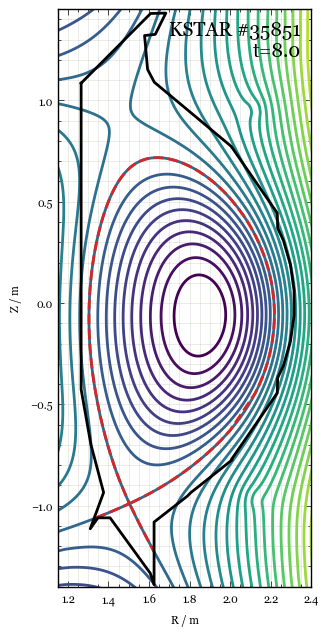

In [4]:
sn = '35851'
pick_time = 8.0
zoom_fac = 10

axxlims = 1.15, 2.4
axylims = -1.4, 1.45
iaxxlims = 1.615, 1.64
iaxylims = -1.3, -1.15
baxxlims = 0.0, 18.0

axr=iaxr=baxr=0.01
fig, ax = plt.subplots(1, 1, figsize=(3.5, 7.5))

with h5py.File(psi_data_filename, 'r') as h5:
    tt = h5[sn]['EFIT01']['\\PSIRZ']['dim2'][:] * 1e-3
    ttind = np.argmin(np.abs(tt - pick_time))
    R = h5[sn]['EFIT01']['\\PSIRZ']['dim0'][:]
    Z = h5[sn]['EFIT01']['\\PSIRZ']['dim1'][:]
    psi = h5[sn]['EFIT01']['\\PSIRZ']['data'][ttind, :, :]
    a = h5[sn]['EFIT01']['\\SSIMAG']['data'][ttind]
    b = h5[sn]['EFIT01']['\\SSIBRY']['data'][ttind]
    psin = (psi - a) / (b - a)
    Ri = ndimage.zoom(R, zoom_fac)
    Zi = ndimage.zoom(Z, zoom_fac)
    psini = ndimage.zoom(psin, zoom_fac)
    wall = h5[sn]['EFIT01']['\\LIM']['data'][:]

ax.contour(Ri, Zi, psini, np.linspace(0.1, 2.8, 28))
# fig, ax = plt.subplots()
# null_surface = ax.contour(Ri, Zi, psini).get_paths()[0].vertices
# plt.close(fig)
sep = get_sep(Ri, Zi, psini, wall)
for sax in [ax]:
    sax.plot(sep[0], sep[1], color='tab:red', ls='--')
    sax.plot(wall[:, 0], wall[:, 1], color='black')
    # sax.scatter(LPr, LPz, 25, color='red')

ax.set_xlim(axxlims)
ax.set_ylim(axylims)
ax.set_aspect('equal')
ax.set_xlabel('R / m')
ax.set_ylabel('Z / m')


ax.text(axxlims[1]-0.05, axylims[1] - 0.05, f'KSTAR #{sn}\nt={pick_time}',
        horizontalalignment='right', verticalalignment='top', fontsize=14)

with h5py.File(data_filename, 'r') as h5:
    tt = h5[sn]['PCS_KSTAR']['\\DVSIP']['dim0'][:]
    ip = -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][:]
    beta = h5[sn]['PCS_KSTAR']['\\EFSBETAN']['data'][:]

# fig.savefig(f'../figures/KSTAR_psini_contour_{sn}.pdf', bbox_inches='tight')

In [5]:
# sn = '35855'
# pick_time = 8.0
# zoom_fac = 10

# axxlims = 1.15, 2.4
# axylims = -1.4, 1.45
# iaxxlims = 1.615, 1.64
# iaxylims = -1.3, -1.15
# baxxlims = 0.0, 18.0

# axr=iaxr=baxr=0.01
# fig, ax = plt.subplots(1, 1, figsize=(3.5, 7.5))

# with h5py.File(psi_data_filename, 'r') as h5:
#     tt = h5[sn]['EFIT01']['\\PSIRZ']['dim2'][:] * 1e-3
#     ttind = np.argmin(np.abs(tt - pick_time))
#     R = h5[sn]['EFIT01']['\\PSIRZ']['dim0'][:]
#     Z = h5[sn]['EFIT01']['\\PSIRZ']['dim1'][:]
#     psi = h5[sn]['EFIT01']['\\PSIRZ']['data'][ttind, :, :]
#     a = h5[sn]['EFIT01']['\\SSIMAG']['data'][ttind]
#     b = h5[sn]['EFIT01']['\\SSIBRY']['data'][ttind]
#     psin = (psi - a) / (b - a)
#     Ri = ndimage.zoom(R, zoom_fac)
#     Zi = ndimage.zoom(Z, zoom_fac)
#     psini = ndimage.zoom(psin, zoom_fac)
#     wall = h5[sn]['EFIT01']['\\LIM']['data'][:]

# # ax.contour(Ri, Zi, psini, np.linspace(1.0925534, 1.0925536, 10))
# # fig, ax = plt.subplots()
# # null_surface = ax.contour(Ri, Zi, psini).get_paths()[0].vertices
# # plt.close(fig)
# sep = get_sep(Ri, Zi, psini, wall)
# sep2 = get_sep(Ri, Zi, psini, wall, z_upper_lim=2.0, sep_psin=1.0925535)
# break_ind = np.argmax(np.abs(np.diff(sep2[1][:])))
# for sax in [ax]:
#     sax.plot(sep[0], sep[1], color='tab:red', ls='--')
#     sax.plot(sep2[0][100:break_ind+1], sep2[1][100:break_ind+1], 1, color='tab:red', ls=':', lw=1)
#     sax.plot(sep2[0][break_ind+1:], sep2[1][break_ind+1:], 1, color='tab:red', ls=':', lw=1)
#     sax.plot(wall[:, 0], wall[:, 1], color='black')
#     # sax.scatter(LPr, LPz, 25, color='red')

# # ax.set_xlim(axxlims)
# # ax.set_ylim(axylims)
# # ax.set_aspect('equal')
# ax.set_xlabel('R / m')
# ax.set_ylabel('Z / m')

# ax.set_ylim(0.911, 0.914)
# ax.set_xlim(1.45, 1.46)




# # ax.text(axxlims[1]-0.05, axylims[1] - 0.05, f'KSTAR #{sn}\nt={pick_time}',
# #         horizontalalignment='right', verticalalignment='top', fontsize=14)

# with h5py.File(data_filename, 'r') as h5:
#     tt = h5[sn]['PCS_KSTAR']['\\DVSIP']['dim0'][:]
#     ip = -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][:]
#     beta = h5[sn]['PCS_KSTAR']['\\EFSBETAN']['data'][:]

# # fig.savefig(f'../figures/KSTAR_psini_contour_{sn}.pdf', bbox_inches='tight')

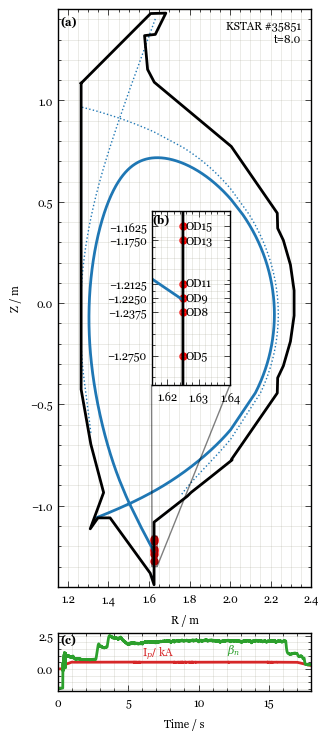

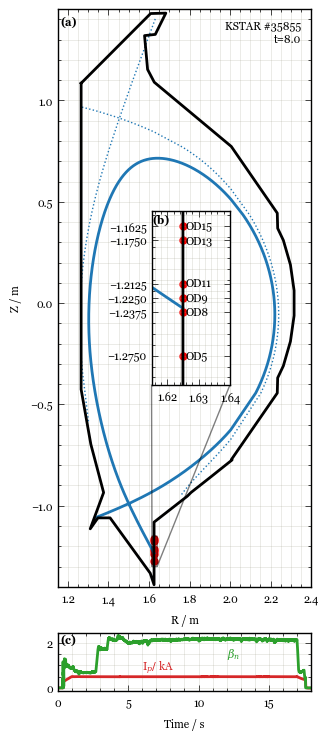

In [6]:
for sn, sep_psin in zip(['35851', '35855'], [1.0935908, 1.0925535]):
    pick_time = 8.0
    zoom_fac = 10

    axxlims = 1.15, 2.4
    axylims = -1.4, 1.45
    iaxxlims = 1.615, 1.64
    iaxylims = -1.3, -1.15
    baxxlims = 0.0, 18.0

    axr=iaxr=baxr=0.01
    fig, ax = plt.subplots(1, 1, figsize=(3.5, 7.5))

    with h5py.File(psi_data_filename, 'r') as h5:
        tt = h5[sn]['EFIT01']['\\PSIRZ']['dim2'][:] * 1e-3
        ttind = np.argmin(np.abs(tt - pick_time))
        R = h5[sn]['EFIT01']['\\PSIRZ']['dim0'][:]
        Z = h5[sn]['EFIT01']['\\PSIRZ']['dim1'][:]
        psi = h5[sn]['EFIT01']['\\PSIRZ']['data'][ttind, :, :]
        a = h5[sn]['EFIT01']['\\SSIMAG']['data'][ttind]
        b = h5[sn]['EFIT01']['\\SSIBRY']['data'][ttind]
        psin = (psi - a) / (b - a)
        Ri = ndimage.zoom(R, zoom_fac)
        Zi = ndimage.zoom(Z, zoom_fac)
        psini = ndimage.zoom(psin, zoom_fac)
        wall = h5[sn]['EFIT01']['\\LIM']['data'][:]

    # Create the inset axes
    inset_ax = ax.inset_axes([0.37, 0.35, 0.31, 0.3]) # [x, y, width, height]

    sep = get_sep(Ri, Zi, psini, wall)
    sep2 = get_sep(Ri, Zi, psini, wall, z_upper_lim=2.0, sep_psin=sep_psin)
    break_ind = np.argmax(np.abs(np.diff(sep2[1])))
    for sax in [ax, inset_ax]:
        sax.plot(sep[0], sep[1], color='tab:blue')
        sax.plot(sep2[0][100:break_ind+1], sep2[1][100:break_ind+1], 1, color='tab:blue', ls=':', lw=1)
        sax.plot(sep2[0][break_ind+1:], sep2[1][break_ind+1:], 1, color='tab:blue', ls=':', lw=1)
        sax.plot(wall[:, 0], wall[:, 1], color='black')
        sax.scatter(LPr, LPz, 25, color='red')

    ax.set_xlim(axxlims)
    ax.set_ylim(axylims)
    ax.set_aspect('equal')
    ax.set_xlabel('R / m')
    ax.set_ylabel('Z / m')

    inset_ax.set_xlim(iaxxlims) # Set the limits for the zoomed-in region
    inset_ax.set_ylim(iaxylims)
    inset_ax.set_yticks(LPz)

    for ii, od in enumerate(LPlabels):
        inset_ax.text(LPr[ii] + 0.001, LPz[ii], od, verticalalignment='center')

    # Draw a rectangle on the main plot to indicate the zoomed-in region
    ax.indicate_inset_zoom(inset_ax, edgecolor="black")

    ax.text(axxlims[1]-0.05, axylims[1] - 0.05, f'KSTAR #{sn}\nt={pick_time}',
            horizontalalignment='right', verticalalignment='top')

    with h5py.File(data_filename, 'r') as h5:
        tt = h5[sn]['PCS_KSTAR']['\\DVSIP']['dim0'][:]
        ip = -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][:]
        beta = h5[sn]['PCS_KSTAR']['\\EFSBETAN']['data'][:]

    bottom_ax = ax.inset_axes([0.0, -0.18, 1.0, 0.1])
    bottom_ax.plot(tt, ip, color='tab:red')
    bottom_ax.plot(tt, beta, color='tab:green')
    bottom_ax.set_xlim(baxxlims)
    bottom_ax.text(6.0, max(ip), 'I' + r'$_{p} / $' + ' kA',
                verticalalignment='bottom', color='tab:red')
    bottom_ax.text(12.0, max(beta)*0.8, r'$\beta_{n}$',
                verticalalignment='top', color='tab:green')
    bottom_ax.set_xlabel('Time / s')

    add_subplot_ind(ax, axr, '(a)')
    add_subplot_ind(inset_ax, iaxr, '(b)')
    add_subplot_ind(bottom_ax, baxr, '(c)')

    # fig.savefig(f'../figures/RefShot_{sn}.pdf', bbox_inches='tight')

In [7]:
lporder = 4
fcut = 50
ds = 10
LPFsos = signal.butter(lporder, fcut, 'low', output='sos', fs=1000)

[ 0.20485754  0.00502485  0.00167086  0.05       -0.00505445]


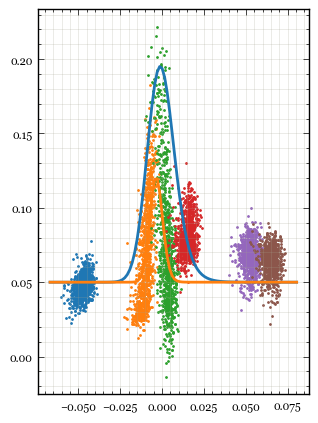

In [8]:
ms = 1
use_LP = [1, 2]

ary = 0.05
arl = 0.01
arhl = 0.005
arhw = 0.01
arw = 0.001

starttime = 7
endtime = 16

def strike_profile(z, A, mu, sig, offset):
    return A * np.exp(-((z- mu)/sig)**2) + offset


def eich_profile(z, A, S, l, offset, mu):
    return A * np.exp((S/l/2)**2 - z/l + mu/l) * special.erfc(S/l/2 - z/S + mu/S) + offset

trial_p = [0.3, 0.01, 0.005, 0.05, -0.005]



fig, axs = plt.subplots(1, 1, figsize=(3.5, 5),
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.05})

with h5py.File(data_filename, 'r') as h5:
    sn = '35851'
    ax = axs
    tt = h5[sn]['PCS_KSTAR']['\\PCLPEP51']['dim0'][:]
    startind = np.argmin(np.abs(tt - starttime))
    endind = np.argmin(np.abs(tt - endtime))
    LPdata = get_LP_data(h5, sn, LPFsos)
    Zosp = h5[sn]['EFIT01']['\\ZVSOUT']['data'][:]
    z_all = []
    i_all = []
    for ii in range(len(LPz)):
        z = LPz[ii] - Zosp[startind:endind:ds]
        isat = LPdata[ii, startind:endind:ds]
        ax.scatter(z, isat, ms, label=LPlabels[ii])
        if ii in use_LP:
            z_all += list(z)
            i_all += list(isat)
    z_all = np.array(z_all)
    i_all = np.array(i_all)
    fitz = np.linspace(*ax.get_xlim(), 100)
    ax.plot(fitz, eich_profile(fitz, *trial_p))
    popt, pcov = curve_fit(eich_profile, z_all, i_all,
                           bounds=([0.1, 0.001, 1e-4, 0.05, -0.01],
                                   [10.0, 0.02, 0.1, 0.15, -0.00]))
    print(popt)
    ax.plot(fitz, eich_profile(fitz, *popt))

In [9]:
z_hwhm = 8e-3
sig = z_hwhm / np.sqrt(np.log(2))

half_probe_dis = 12.5e-3/2

lowest_peak = np.exp(-half_probe_dis**2/sig**2)
print(lowest_peak)

mu = np.linspace(-half_probe_dis, half_probe_dis, 100)
peak_err = 1 - np.exp(-mu**2 / sig**2)
print("Mean error: ", np.mean(peak_err))
print("Median error: ", np.median(peak_err))

0.6550370600639169
Mean error:  0.12700756292896534
Median error:  0.1023249993295901


In [10]:
spc_bound = 2.35e-3
mu = np.linspace(-spc_bound, spc_bound, 100)
peak_err = 1 - np.exp(-mu**2 / sig**2)
print("Mean error: ", np.mean(peak_err))
print("Median error: ", np.median(peak_err))

Mean error:  0.019972832257695125
Median error:  0.015146394713149769


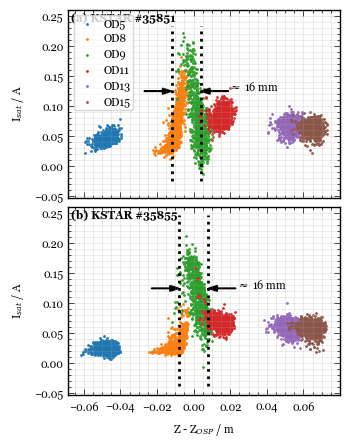

In [11]:
ms = 1
use_LP = [1, 2]

ary = 0.125
arl = 0.01
arhl = 0.005
arhw = 0.01
arw = 0.001

starttime = 7
endtime = 16

trial_p = [0.15, -0.005, 0.006, 0.1, 20]

fig, axs = plt.subplots(2, 1, figsize=(3.5, 5),
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0.05})

with h5py.File(data_filename, 'r') as h5:
    sn = '35851'
    ax = axs[0]
    tt = h5[sn]['PCS_KSTAR']['\\PCLPEP51']['dim0'][:]
    startind = np.argmin(np.abs(tt - starttime))
    endind = np.argmin(np.abs(tt - endtime))
    LPdata = get_LP_data(h5, sn, LPFsos)
    # Zosp = h5[sn]['EFIT01']['\\ZVSOUT']['data'][:]
    Zosp = signal.sosfilt(LPFsos, h5[sn]['EFIT01']['\\ZVSOUT']['data'][:])
    z_all = []
    i_all = []
    for ii in range(len(LPz)):
        z = LPz[ii] - Zosp[startind:endind:ds]
        isat = LPdata[ii, startind:endind:ds]
        ax.scatter(z, isat, ms, label=LPlabels[ii])
    
    hwloc = [-0.012, 0.004]
    ax.vlines(hwloc, *ax.get_ylim(), color="black", ls=':')
    ax.arrow(x=hwloc[0] - arl - arhl, y=ary, dx=arl, dy=0, width=arw,
             head_width=arhw, head_length=arhl, fc='k')
    ax.arrow(x=hwloc[1] + arl + arhl, y=ary, dx=-arl, dy=0, width=arw,
             head_width=arhw, head_length=arhl, fc='k')
    ax.text(hwloc[1] + arl + arhl, ary, r"$\approx$" + f" {round((hwloc[1] - hwloc[0])*1e3)} mm")
    ax.set_ylabel("I$_{sat}$ / A")
    

    sn = '35855'
    ax = axs[1]
    tt = h5[sn]['PCS_KSTAR']['\\PCLPEP51']['dim0'][:]
    startind = np.argmin(np.abs(tt - starttime))
    endind = np.argmin(np.abs(tt - endtime))
    LPdata = get_LP_data(h5, sn, LPFsos)
    Zosp = signal.sosfilt(LPFsos, h5[sn]['EFIT01']['\\ZVSOUT']['data'][:])
    z_all = []
    i_all = []
    for ii in range(len(LPz)):
        z = LPz[ii] - Zosp[startind:endind:ds]
        isat = LPdata[ii, startind:endind:ds]
        ax.scatter(z, isat, ms, label=LPlabels[ii])
    hwloc = [-0.008, 0.008]
    ax.vlines(hwloc, *ax.get_ylim(), color="black", ls=':')
    ax.arrow(x=hwloc[0] - arl - arhl, y=ary, dx=arl, dy=0, width=arw,
             head_width=arhw, head_length=arhl, fc='k')
    ax.arrow(x=hwloc[1] + arl + arhl, y=ary, dx=-arl, dy=0, width=arw,
             head_width=arhw, head_length=arhl, fc='k')
    ax.text(hwloc[1] + arl + arhl, ary, r"$\approx$" + f" {round((hwloc[1] - hwloc[0])*1e3)} mm")
    ax.set_ylabel("I$_{sat}$ / A")

axs[0].legend()
axs[1].set_xlabel('Z - Z$_{OSP}$ / m')

add_subplot_ind(axs[0], 0.01, f"(a) KSTAR #35851")
add_subplot_ind(axs[1], 0.01, f"(b) KSTAR #35855")
# fig.savefig('../figures/StrikePointWidthBothRefs.pdf', bbox_inches='tight')

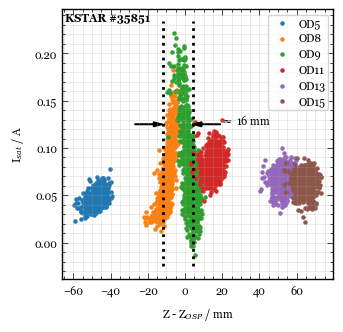

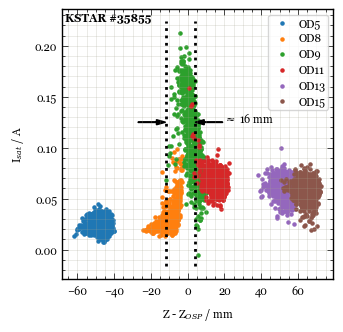

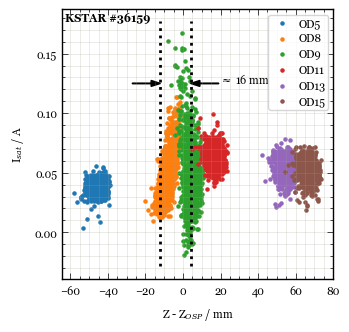

In [12]:
ms = 5
use_LP = [1, 2]

ary = 0.125
arl = 10
arhl = 5
arhw = 0.005
arw = 0.0005

starttime = 7
endtime = 16

def strike_profile(z, A, mu, sig, offset):
    return A * np.exp(-((z- mu)/sig)**2) + offset

def eich_profile(z, A, mu, sig, offset, P):
    return A * np.exp(((z- mu)/sig)) * special.erfc(-z*P) + offset

trial_p = [0.15, -0.005, 0.006, 0.1, 20]

for sn in ['35851', '35855', '36159']:

    fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))

    with h5py.File(data_filename, 'r') as h5:
        tt = h5[sn]['PCS_KSTAR']['\\PCLPEP51']['dim0'][:]
        startind = np.argmin(np.abs(tt - starttime))
        endind = np.argmin(np.abs(tt - endtime))
        LPdata = get_LP_data(h5, sn, LPFsos)
        Zosp = signal.sosfilt(LPFsos, h5[sn]['EFIT01']['\\ZVSOUT']['data'][:])
        z_all = []
        i_all = []
        for ii in range(len(LPz)):
            z = (LPz[ii] - Zosp[startind:endind:ds]) * 1e3
            isat = LPdata[ii, startind:endind:ds]
            ax.scatter(z, isat, ms, label=LPlabels[ii])
        
        hwloc = [-12, 4]
        ax.vlines(hwloc, *ax.get_ylim(), color="black", ls=':')
        ax.arrow(x=hwloc[0] - arl - arhl, y=ary, dx=arl, dy=0, width=arw,
                head_width=arhw, head_length=arhl, fc='k')
        ax.arrow(x=hwloc[1] + arl + arhl, y=ary, dx=-arl, dy=0, width=arw,
                head_width=arhw, head_length=arhl, fc='k')
        ax.text(hwloc[1] + arl + arhl, ary, r"$\approx$" + f" {round((hwloc[1] - hwloc[0]))} mm")
        ax.set_ylabel("I$_{sat}$ / A")
    # ax.set_ylim(0.05, 0.26)
    ax.set_xlabel('Z - Z$_{OSP}$ / mm')
    ax.legend()
    add_subplot_ind(ax, 0.01, f"KSTAR #{sn}")

    # fig.savefig(f'../figures/StrikePointWidth_{sn}.pdf', bbox_inches='tight')

/var/folders/hb/_qb1q5r90qj02zv4c0yzxg5w0000gq/T/ipykernel_57009/804839149.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axafrac.legend(ncols=2,


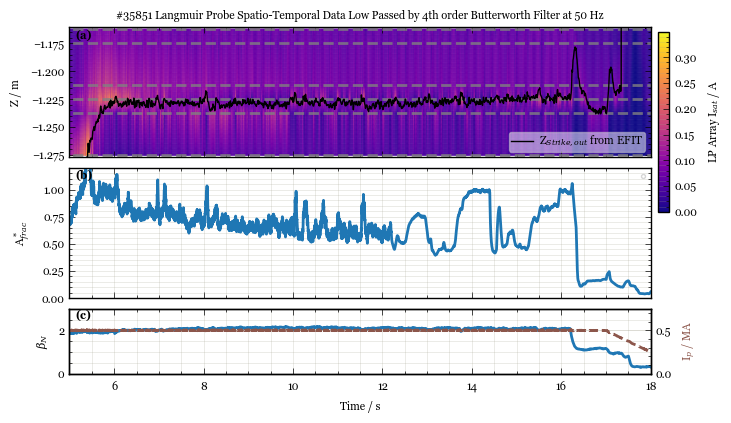

In [54]:
sn = '35851'

vmin = 0.0
vmax = 0.2
starttime = 5.0
endtime = 18.0
colormap = cm.plasma

fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0.1, 'height_ratios':[1.0, 1.0, 0.5]},
                    figsize=(7.5, 4.5))
ax = axs[0]
axafrac = axs[1]
axbeta = axs[2]
with h5py.File(data_filename, 'r') as h5:
    tt, afrac = ch(h5, sn, 'PCS_KSTAR', '\\DVSAFRAC')
    axafrac.plot(tt, afrac * 0.5)


    axbeta.plot(h5[sn]['PCS_KSTAR']['\\EFSBETAN']['dim0'][:],
            h5[sn]['PCS_KSTAR']['\\EFSBETAN']['data'][:],)
    axip = axbeta.twinx()

    axip.plot(h5[sn]['PCS_KSTAR']['\\DVSIP']['dim0'][:],
                -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][:], ls='--', color='tab:brown')
    
    tt = h5[sn]['PCS_KSTAR']['\\PCLPEP51']['dim0'][:]
    LPdata = get_LP_data(h5, sn, LPFsos)
    
    LPz_arr = np.linspace(min(LPz), max(LPz), 100)
    # LPcs = interpolate.CubicSpline(LPz, LPdata, axis=0, bc_type='natural')
    # LPplot = ax.pcolor(tt[::20], LPz_arr, LPcs(LPz_arr)[:, ::20], cmap=colormap, shading='nearest', vmin=vmin, vmax=vmax, label=None, edgecolor='face')
    LP_lin = np.zeros((len(LPz_arr), len(tt)))
    for ii in range(len(tt)):
        LP_lin[:, ii] = np.interp(LPz_arr, LPz, LPdata[:, ii])
    LPplot = ax.pcolor(tt[::20], LPz_arr, LP_lin[:, ::20], cmap=colormap, shading='nearest',
                       vmin=0,
                       vmax=np.max(LP_lin[:, tt>starttime]),
                       label=None, edgecolor='face')

    ax.hlines(LPz, color='grey', ls='--', xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], alpha=0.8)

    try:
        ax.plot(h5[sn]['EFIT01']['\\ZVSOUT']['dim0'][:],
                h5[sn]['EFIT01']['\\ZVSOUT']['data'][:],
                color='black',
                linewidth=1,
                label='Z' + r'$_{Strike, out}$' + ' from EFIT')
    except BaseException:
        pass
    
    # for ii in range(len(tt)):
    #     if tt[ii] > starttime and  -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][ii] < 0.4:
    #         endtime = tt[ii]
    #         # print(endtime)
    #         break

caxl = fig.add_axes([0.91, 0.47, 0.015, 0.4])
fig.colorbar(LPplot, cax = caxl, label='LP Array I' + r'$_{sat}$' + ' / A')

ax.set_ylim(min(LPz)-0.002, max(LPz)+0.002)
axafrac.set_ylim(-0., 1.2)
# caxN2.set_ylim(-1, 6)
axbeta.set_ylim(0, 3.0)
axip.set_ylim(0, 0.75)

ax.set_ylabel('Z / m')
axafrac.set_ylabel('A' + '$_{frac}^*$')
axbeta.set_ylabel(r'$\beta_N$')
axip.set_ylabel('I' + r'$_p$' + ' / MA', color='tab:brown')

ax.legend(
    # loc=(0.6, 0.05), 
    loc='lower right',
    framealpha=0.5)
axafrac.legend(ncols=2,
            #    loc=(0.6, 0.75),
               loc='upper right',
)


axs[-1].set_xlabel('Time / s')

axs[-1].set_xlim((starttime, endtime))

add_subplot_ind(ax, 0.01, '(a)')
add_subplot_ind(axafrac, 0.01, '(b)')
add_subplot_ind(axbeta, 0.01, '(c)')

ax.grid(False, 'both')
axip.yaxis.grid(False, which='minor')

axs[0].set_title(f'#{sn} Langmuir Probe Spatio-Temporal Data Low Passed by {lporder}th order Butterworth Filter at {fcut} Hz')

# fig.savefig(f'../figures/DetCtrl_2D_{sn}.pdf', bbox_inches='tight')

/var/folders/hb/_qb1q5r90qj02zv4c0yzxg5w0000gq/T/ipykernel_57009/1383628212.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axafrac.legend(ncols=2,


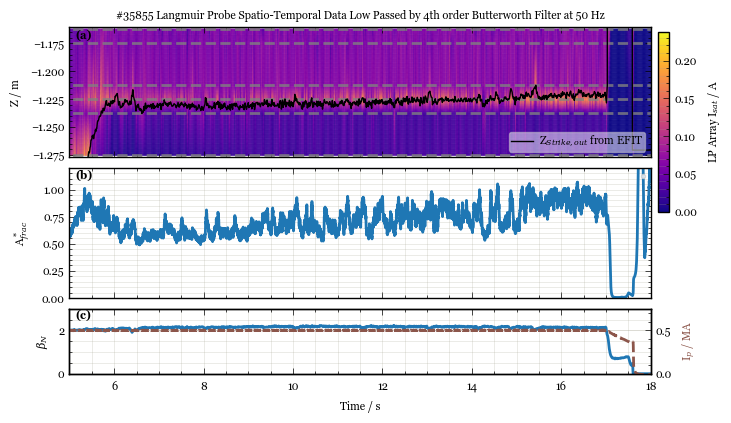

In [55]:
sn = '35855'

vmin = 0.0
vmax = 0.2
starttime = 5.0
endtime = 18
colormap = cm.plasma

fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0.1, 'height_ratios':[1.0, 1.0, 0.5]},
                    figsize=(7.5, 4.5))
ax = axs[0]
axafrac = axs[1]
axbeta = axs[2]
with h5py.File(data_filename, 'r') as h5:
    tt, afrac = ch(h5, sn, 'PCS_KSTAR', '\\DVSAFRAC')
    axafrac.plot(tt, afrac)


    axbeta.plot(h5[sn]['PCS_KSTAR']['\\EFSBETAN']['dim0'][:],
            h5[sn]['PCS_KSTAR']['\\EFSBETAN']['data'][:],)
    axip = axbeta.twinx()

    axip.plot(h5[sn]['PCS_KSTAR']['\\DVSIP']['dim0'][:],
                -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][:], ls='--', color='tab:brown')
    
    tt = h5[sn]['PCS_KSTAR']['\\PCLPEP51']['dim0'][:]
    LPdata = get_LP_data(h5, sn, LPFsos)
    
    LPz_arr = np.linspace(min(LPz), max(LPz), 100)
    # LPcs = interpolate.CubicSpline(LPz, LPdata, axis=0, bc_type='natural')
    # LPplot = ax.pcolor(tt[::20], LPz_arr, LPcs(LPz_arr)[:, ::20], cmap=colormap, shading='nearest', vmin=vmin, vmax=vmax, label=None, edgecolor='face')
    LP_lin = np.zeros((len(LPz_arr), len(tt)))
    for ii in range(len(tt)):
        LP_lin[:, ii] = np.interp(LPz_arr, LPz, LPdata[:, ii])
    LPplot = ax.pcolor(tt[::20], LPz_arr, LP_lin[:, ::20], cmap=colormap, shading='nearest',
                       vmin=0,
                       vmax=np.max(LP_lin[:, tt>starttime]),
                       label=None, edgecolor='face')

    ax.hlines(LPz, color='grey', ls='--', xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], alpha=0.8)

    try:
        ax.plot(h5[sn]['EFIT01']['\\ZVSOUT']['dim0'][:],
                h5[sn]['EFIT01']['\\ZVSOUT']['data'][:],
                color='black',
                linewidth=1,
                label='Z' + r'$_{Strike, out}$' + ' from EFIT')
    except BaseException:
        pass
    
    # for ii in range(len(tt)):
    #     if tt[ii] > starttime and  -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][ii] < 0.4:
    #         endtime = tt[ii]
    #         # print(endtime)
    #         break

caxl = fig.add_axes([0.91, 0.47, 0.015, 0.4])
fig.colorbar(LPplot, cax = caxl, label='LP Array I' + r'$_{sat}$' + ' / A')

ax.set_ylim(min(LPz)-0.002, max(LPz)+0.002)
axafrac.set_ylim(-0., 1.2)
# caxN2.set_ylim(-1, 6)
axbeta.set_ylim(0, 3.0)
axip.set_ylim(0, 0.75)

ax.set_ylabel('Z / m')
axafrac.set_ylabel('A' + '$_{frac}^*$')
axbeta.set_ylabel(r'$\beta_N$')
axip.set_ylabel('I' + r'$_p$' + ' / MA', color='tab:brown')

ax.legend(
    # loc=(0.6, 0.05), 
    loc='lower right',
    framealpha=0.5)
axafrac.legend(ncols=2,
            #    loc=(0.6, 0.75),
               loc='upper right',
)


axs[-1].set_xlabel('Time / s')

axs[-1].set_xlim((starttime, endtime))

add_subplot_ind(ax, 0.01, '(a)')
add_subplot_ind(axafrac, 0.01, '(b)')
add_subplot_ind(axbeta, 0.01, '(c)')

ax.grid(False, 'both')
axip.yaxis.grid(False, which='minor')

axs[0].set_title(f'#{sn} Langmuir Probe Spatio-Temporal Data Low Passed by {lporder}th order Butterworth Filter at {fcut} Hz')

# fig.savefig(f'../figures/DetCtrl_2D_{sn}.pdf', bbox_inches='tight')

/var/folders/hb/_qb1q5r90qj02zv4c0yzxg5w0000gq/T/ipykernel_57009/1310619796.py:75: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axafrac.legend(ncols=2,


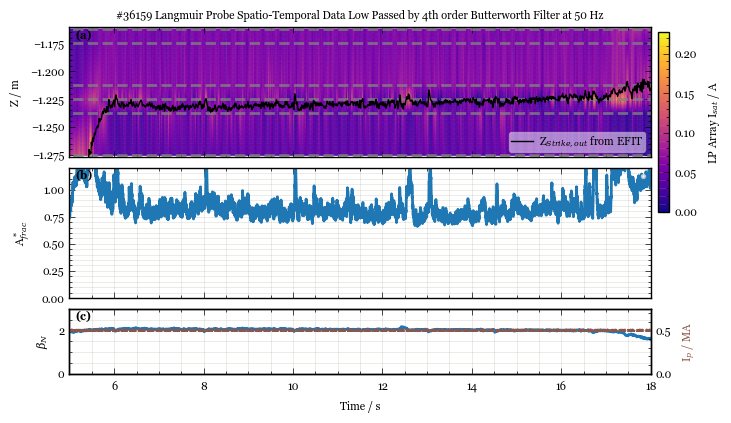

In [56]:
sn = '36159'

vmin = 0.0
vmax = 0.15
starttime = 5.0
endtime = 18
colormap = cm.plasma

fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0.1, 'height_ratios':[1.0, 1.0, 0.5]},
                    figsize=(7.5, 4.5))
ax = axs[0]
axafrac = axs[1]
axbeta = axs[2]
with h5py.File(data_filename, 'r') as h5:
    tt, afrac = ch(h5, sn, 'PCS_KSTAR', '\\DVSAFRAC')
    axafrac.plot(tt, afrac)


    axbeta.plot(h5[sn]['PCS_KSTAR']['\\EFSBETAN']['dim0'][:],
            h5[sn]['PCS_KSTAR']['\\EFSBETAN']['data'][:],)
    axip = axbeta.twinx()

    axip.plot(h5[sn]['PCS_KSTAR']['\\DVSIP']['dim0'][:],
                -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][:], ls='--', color='tab:brown')
    
    tt = h5[sn]['PCS_KSTAR']['\\PCLPEP51']['dim0'][:]
    LPdata = get_LP_data(h5, sn, LPFsos)
    
    LPz_arr = np.linspace(min(LPz), max(LPz), 100)
    # LPcs = interpolate.CubicSpline(LPz, LPdata, axis=0, bc_type='natural')
    # LPplot = ax.pcolor(tt[::20], LPz_arr, LPcs(LPz_arr)[:, ::20], cmap=colormap, shading='nearest', vmin=vmin, vmax=vmax, label=None, edgecolor='face')
    LP_lin = np.zeros((len(LPz_arr), len(tt)))
    for ii in range(len(tt)):
        LP_lin[:, ii] = np.interp(LPz_arr, LPz, LPdata[:, ii])
    LPplot = ax.pcolor(tt[::20], LPz_arr, LP_lin[:, ::20], cmap=colormap, shading='nearest',
                       vmin=0,
                       vmax=np.max(LP_lin[:, tt>starttime]),
                       label=None, edgecolor='face')

    ax.hlines(LPz, color='grey', ls='--', xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], alpha=0.8)

    try:
        ax.plot(h5[sn]['EFIT01']['\\ZVSOUT']['dim0'][:],
                h5[sn]['EFIT01']['\\ZVSOUT']['data'][:],
                color='black',
                linewidth=1,
                label='Z' + r'$_{Strike, out}$' + ' from EFIT')
    except BaseException:
        pass
    
    # for ii in range(len(tt)):
    #     if tt[ii] > starttime and  -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][ii] < 0.4:
    #         endtime = tt[ii]
    #         # print(endtime)
    #         break

caxl = fig.add_axes([0.91, 0.47, 0.015, 0.4])
fig.colorbar(LPplot, cax = caxl, label='LP Array I' + r'$_{sat}$' + ' / A')

ax.set_ylim(min(LPz)-0.002, max(LPz)+0.002)
axafrac.set_ylim(-0., 1.2)
# caxN2.set_ylim(-1, 6)
axbeta.set_ylim(0, 3.0)
axip.set_ylim(0, 0.75)

ax.set_ylabel('Z / m')
axafrac.set_ylabel('A' + '$_{frac}^*$')
axbeta.set_ylabel(r'$\beta_N$')
axip.set_ylabel('I' + r'$_p$' + ' / MA', color='tab:brown')

ax.legend(
    # loc=(0.6, 0.05), 
    loc='lower right',
    framealpha=0.5)
axafrac.legend(ncols=2,
            #    loc=(0.6, 0.75),
               loc='upper right',
)


axs[-1].set_xlabel('Time / s')

axs[-1].set_xlim((starttime, endtime))

add_subplot_ind(ax, 0.01, '(a)')
add_subplot_ind(axafrac, 0.01, '(b)')
add_subplot_ind(axbeta, 0.01, '(c)')

ax.grid(False, 'both')
axip.yaxis.grid(False, which='minor')

axs[0].set_title(f'#{sn} Langmuir Probe Spatio-Temporal Data Low Passed by {lporder}th order Butterworth Filter at {fcut} Hz')

# fig.savefig(f'../figures/DetCtrl_2D_{sn}.pdf', bbox_inches='tight')

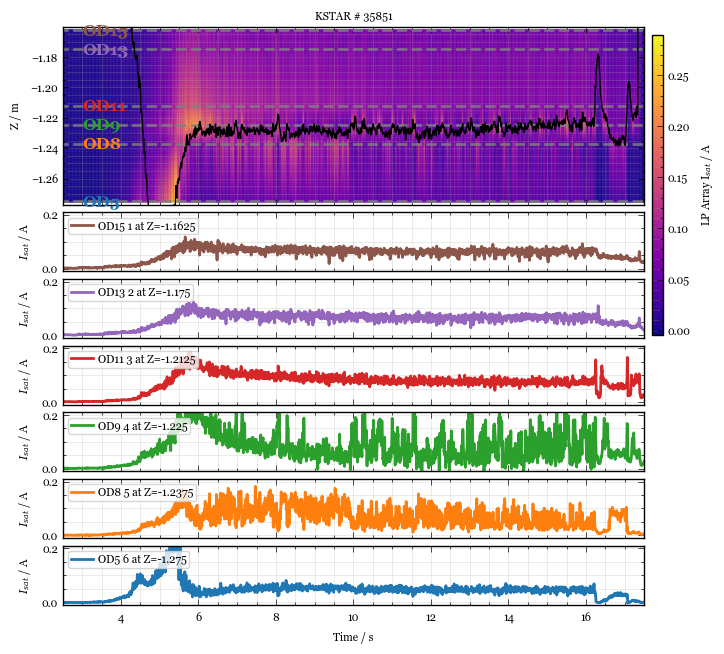

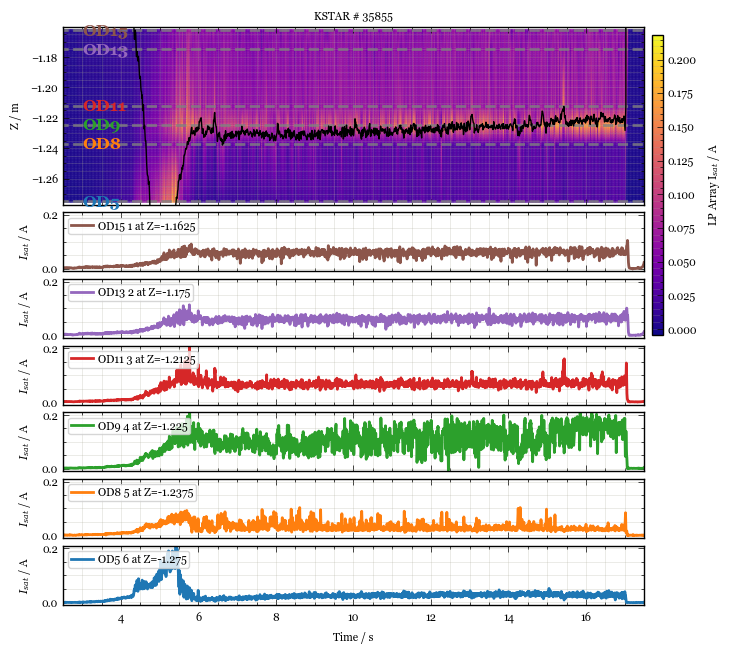

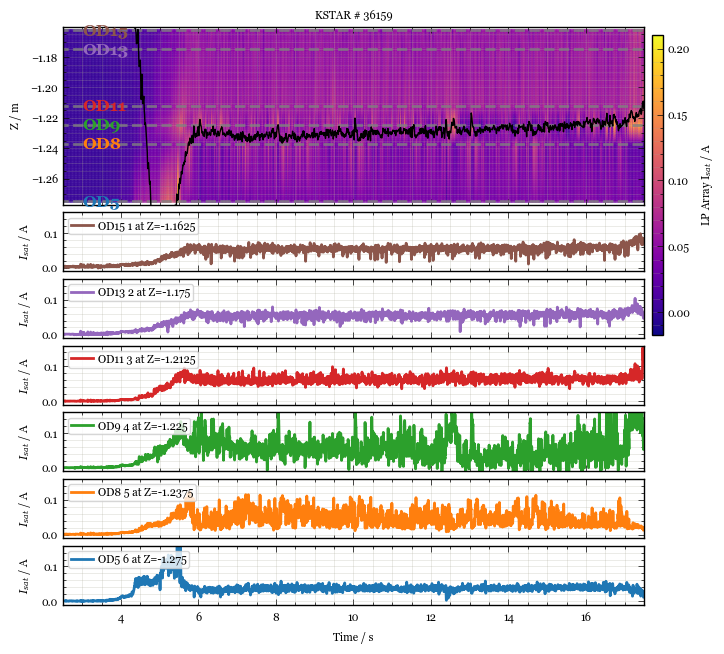

In [23]:
for sn, vmax in zip(['35851', '35855', '36159'], [0.2, 0.2, 0.15]):
    vmin=0.0
    fig, axs = plt.subplots(len(LPz) + 1, 1, sharex=True, figsize=(7.5, 7.5),
                            gridspec_kw={'hspace': 0.1, 'height_ratios': [3.0] + [1.0] * len(LPz)})

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    with h5py.File(data_filename, 'r') as h5:
        tt = h5[sn]['PCS_KSTAR']['\\PCLPEP51']['dim0'][:]
        LPdata = get_LP_data(h5, sn, LPFsos)
        for ii in range(len(LPz)):
            axi = len(LPz) - ii
            axs[axi].plot(tt, LPdata[ii, :], label=LPlabels[ii] + f' {axi} at Z={str(LPz[ii])}', color=colors[ii])
            axs[axi].legend(loc='upper left')
            axs[axi].set_ylim(vmin - 0.01, vmax + 0.01)
            axs[axi].set_ylabel('$I_{sat}$ / A')
        
        ax = axs[0]
        LPz_arr = np.linspace(min(LPz), max(LPz), 100)
        # LPcs = interpolate.CubicSpline(LPz, LPdata, axis=0, bc_type='natural')
        # LPplot = ax.pcolor(tt[::20], LPz_arr, LPcs(LPz_arr)[:, ::20], cmap=colormap, shading='nearest', vmin=vmin, vmax=vmax, label=None, edgecolor='face')
        LP_lin = np.zeros((len(LPz_arr), len(tt)))
        for ii in range(len(tt)):
            LP_lin[:, ii] = np.interp(LPz_arr, LPz, LPdata[:, ii])
        LPplot = ax.pcolor(tt[::20], LPz_arr, LP_lin[:, ::20], cmap=colormap, shading='nearest',
                        #    vmin=vmin, vmax=vmax,
                        label=None, edgecolor='face')

        ax.hlines(LPz, color='grey', ls='--', xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], alpha=0.8)
        ax.plot(*ch(h5, sn, 'EFIT01', '\\ZVSOUT'), color='black', linewidth=1, label='Z' + r'$_{Strike, out}$' + ' from EFIT')

    for ii in range(len(LPz)):
        ax.text(3.0, LPz[ii], LPlabels[ii], color=colors[ii], fontsize=12, fontweight='bold', verticalalignment='center')

    caxl = fig.add_axes([0.91, 0.47, 0.015, 0.4])
    fig.colorbar(LPplot, cax = caxl, label='LP Array I' + r'$_{sat}$' + ' / A')

    ax.set_ylabel('Z / m')
    ax.set_ylim(min(LPz)-0.002, max(LPz)+0.002)
    ax.set_xlim(2.5, 17.5)
    axs[-1].set_xlabel('Time / s')

    axs[0].set_title(f'KSTAR # {sn}')

    fig.savefig(f'../figures/LP_data_{sn}.pdf', bbox_inches='tight')

Text(0.5, 0, 'Frequency / Hz')

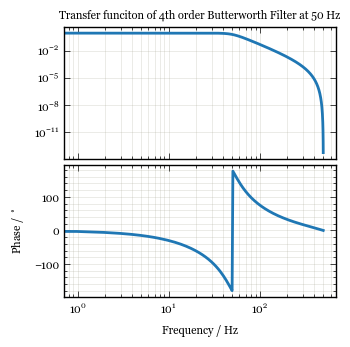

In [24]:
w, H = signal.freqz_sos(LPFsos, fs=1000)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(3.5, 3.5), gridspec_kw={'hspace': 0.05})
ax[0].loglog(w, np.abs(H))
ax[1].semilogx(w, np.angle(H, deg=True))
ax[0].set_title(f'Transfer funciton of {lporder}th order Butterworth Filter at {fcut} Hz')
ax[0].set_xlabel('Magnitude')
ax[1].set_ylabel('Phase / ' + r'$^\circ $')
ax[1].set_xlabel('Frequency / Hz')
# fig.savefig('../figures/LPsos_Bode.pdf', bbox_inches='tight')

## System Identification

In [25]:
def fit_plant(ts, sig, command, tlims=None, pre_ext=5, y_zero_offset=0,
              bounds=([-np.inf, 0, 0], [np.inf, 10, 10]),
              pade_order=10):
    if tlims is None:
        indStart = 0
        indEnd = len(ts)
    else:
        indStart = np.argmin(np.abs(ts - tlims[0]))
        indEnd = np.argmin(np.abs(ts - tlims[1]))

    com_cut = command[indStart:indEnd]
    sig_cut = sig[indStart:indEnd]

    if com_cut[0] == 0.0:
        first_non_zero_ind = np.nonzero(com_cut)[0][0]
        y_zero_offset = np.mean(sig_cut[:first_non_zero_ind])

    sig_cut = sig_cut - y_zero_offset
    
    ts_cut = ts[indStart:indEnd]
    dt = ts_cut[1] - ts_cut[0]
    # ts_pre = np.flip(np.arange(ts[indStart] - dt, ts[indStart] - pre_ext, -dt))
    # ts_ext = np.concatenate([ts_pre, ts])
    ts_ext = np.arange(ts[indStart] - pre_ext, ts[indEnd], dt)
    
    def plant_model(xx, K, tau, L):
        trial_plant_no_delay = ct.tf([K / tau], [1, 1 / tau])
        trial_plant_delay = ct.tf(*ct.pade(L, pade_order))
        trial_plant = ct.series(trial_plant_no_delay, trial_plant_delay)
        xx_pre = xx[0] * np.ones(len(ts_ext) - len(ts_cut))
        xx_ext = np.concatenate([xx_pre, xx])
        _, yy_ext = ct.forced_response(trial_plant, ts_ext, xx_ext, return_x=False)
        yy = yy_ext[len(xx_pre):]
        return yy

    popt, pcov = curve_fit(plant_model, com_cut, sig_cut, bounds=bounds)
    perr = np.sqrt(np.diag(pcov))
    fit_yy = plant_model(com_cut, *popt)

    def fitted_plant(tt, xx, K=popt[0], tau=popt[1], L=popt[2]):
        plant_no_delay = ct.tf([K / tau], [1, 1 / tau])
        plant_delay = ct.tf(*ct.pade(L, pade_order))
        plant = ct.series(plant_no_delay, plant_delay)
        _, yy = ct.forced_response(plant, tt, xx, return_x=False)
        return yy + y_zero_offset


    pmin = popt - perr
    pmax = popt + perr
    pstep = perr / 20
    retDict = {'K': popt[0], 'Kmin': pmin[0], 'Kmax': pmax[0], 'Kstep': pstep[0],
               'tau': popt[1], 'taumin': pmin[1], 'taumax': pmax[1], 'taustep': pstep[1],
               'L': popt[2], 'Lmin': pmin[2], 'Lmax': pmax[2], 'Lstep': pstep[2],
               'fit_tt': ts_cut, 'fit_yy': fit_yy + y_zero_offset,
               'popt': popt, 'perr': perr, 'pcov': pcov, 'fitted_plant': fitted_plant}
    return retDict

def fit_shot(sn, sigpn, compn, tlims=None, pre_ext=5, y_zero_offset=0,
             bounds=([-np.inf, 0, 0], [np.inf, 10, 10]),
             pade_order=10, sig_adhoc_fac=1.0):
    with h5py.File(data_filename, 'r') as h5:
        sigtt, sig = ch(h5, sn, 'PCS_KSTAR', sigpn)
        comptt, com = ch(h5, sn, 'PCS_KSTAR', compn)
    return fit_plant(sigtt, sig * sig_adhoc_fac, com, tlims=tlims, pre_ext=pre_ext,
                     y_zero_offset=y_zero_offset,
                     bounds=bounds,
                     pade_order=pade_order)

def loop_stability(plant_tau=0.726,
                   plant_K=0.323,
                   plant_L=0.139,
                   Kp = 10,
                   Ti = 1.2,
                   Td = 0.726,
                   smooth_tau=0.005):
    
    # Define plant
    plant_no_delay = ct.tf([plant_K / plant_tau], [1, 1 / plant_tau])
    plant_delay = ct.tf(*ct.pade(plant_L, 10))
    plant = ct.series(plant_no_delay, plant_delay)

    # Define PID with pre-smoothing

    PID_presmooth = ct.tf([1 / smooth_tau], [1, 1 / smooth_tau])
    PID_only = ct.tf([Kp * Td * Ti, Kp * Ti, Kp], [Ti, 0])

    PID = ct.series(PID_presmooth, PID_only)

    # Calculate transfer functions
    ff = np.logspace(-2, 2, 400)
    omg = 2 * np.pi * ff
    mag, ph, _ = ct.frequency_response(plant, omg)
    plant_TF = mag * np.exp(1j * ph)

    PID_mag, PID_ph, _ = ct.frequency_response(PID, omg)
    PID_TF = PID_mag * np.exp(1j * PID_ph)

    OLTF = plant_TF * PID_TF
    OLTF_mag = np.abs(OLTF)
    OLTF_ph = np.angle(OLTF, deg=True)

    CLTF = plant_TF / ( 1 + OLTF)

    UGF_ind = np.argmin(np.abs(OLTF_mag - 1.0))
    UGF = ff[UGF_ind]
    phase_margin = OLTF_ph[UGF_ind] + 180
    delay_margin = (phase_margin  * np.pi / 180) / (2 * np.pi * UGF)
    PSF_ind = np.argmin(np.abs(np.unwrap(OLTF_ph * np.pi / 180) + np.pi))
    PSF = ff[PSF_ind]
    gain_margin = 1 / OLTF_mag[PSF_ind]
    return ff, plant_TF, PID_TF, OLTF, CLTF, Kp, smooth_tau, Ti, Td, UGF, PSF, gain_margin, phase_margin, delay_margin


### Afrac SysID

In [26]:
fit_vals = {}

fit_vals['35853'] = fit_shot('35853', '\\DVSAFRAC', '\\GVSPVBLN2',
                            tlims=(6.5, 14.75), pre_ext=0, y_zero_offset=5.0,
                            bounds=([-np.inf, 0, 0], [np.inf, 1, 1.1]), pade_order=20,
                            sig_adhoc_fac=0.5)

fit_vals['35853']


{'K': np.float64(-0.2746821085075045),
 'Kmin': np.float64(-0.27673681724081783),
 'Kmax': np.float64(-0.2726273997741912),
 'Kstep': np.float64(0.00010273543666566684),
 'tau': np.float64(0.9999999999999999),
 'taumin': np.float64(0.9802874156797033),
 'taumax': np.float64(1.0197125843202963),
 'taustep': np.float64(0.000985629216014827),
 'L': np.float64(0.1538823148243131),
 'Lmin': np.float64(0.14837292955251624),
 'Lmax': np.float64(0.15939170009610998),
 'Lstep': np.float64(0.0002754692635898433),
 'fit_tt': array([ 6.5  ,  6.501,  6.502, ..., 14.747, 14.748, 14.749], shape=(8250,)),
 'fit_yy': array([0.97069639, 0.97069639, 0.97069639, ..., 0.2895141 , 0.28909676,
        0.28867984], shape=(8250,)),
 'popt': array([-0.27468211,  1.        ,  0.15388231]),
 'perr': array([0.00205471, 0.01971258, 0.00550939]),
 'pcov': array([[ 4.22182798e-06, -2.70160695e-05,  6.64960836e-07],
        [-2.70160695e-05,  3.88585981e-04, -4.66528933e-05],
        [ 6.64960836e-07, -4.66528933e-05,

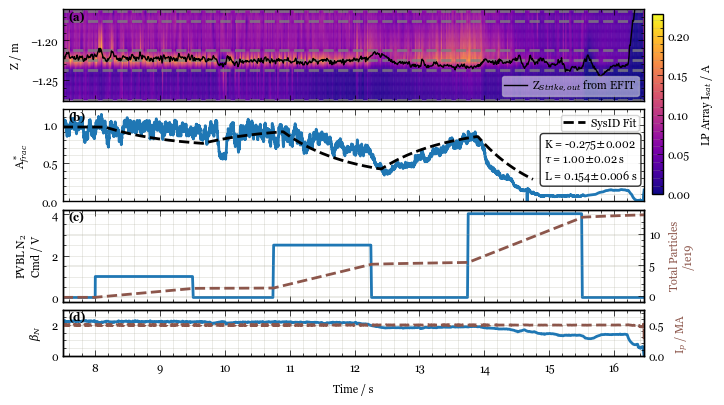

In [33]:
sn = '35853'

vmin = 0.0
vmax = 0.2
starttime = 7.5
colormap = cm.plasma

fig, axs = plt.subplots(4, 1, sharex=True, gridspec_kw={'hspace': 0.1, 'height_ratios':[1.0, 1.0, 1.0, 0.5]},
                    figsize=(7.5, 4.5))
ax = axs[0]
axafrac = axs[1]
axN2 = axs[2]
axbeta = axs[3]
with h5py.File(data_filename, 'r') as h5:
    tt, afrac = ch(h5, sn, 'PCS_KSTAR', '\\DVSAFRAC')
    axafrac.plot(tt, afrac * 0.5)
    axafrac.plot(fit_vals[sn]['fit_tt'], fit_vals[sn]['fit_yy'],
                 label='SysID Fit', color='black', ls='--')

    axN2.plot(*clip_flow(h5, sn, 'L', 'N2'))
    caxN2 = axN2.twinx()
    caxN2.plot(*cum_flow(h5, sn, 'L', 'N2'), ls='--', color='tab:brown')

    axbeta.plot(h5[sn]['PCS_KSTAR']['\\EFSBETAN']['dim0'][:],
            h5[sn]['PCS_KSTAR']['\\EFSBETAN']['data'][:],)
    axip = axbeta.twinx()

    axip.plot(h5[sn]['PCS_KSTAR']['\\DVSIP']['dim0'][:],
                -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][:], ls='--', color='tab:brown')
    
    tt = h5[sn]['PCS_KSTAR']['\\PCLPEP51']['dim0'][:]
    LPdata = get_LP_data(h5, sn, LPFsos)
    
    LPz_arr = np.linspace(min(LPz), max(LPz), 100)
    # LPcs = interpolate.CubicSpline(LPz, LPdata, axis=0, bc_type='natural')
    # LPplot = ax.pcolor(tt[::20], LPz_arr, LPcs(LPz_arr)[:, ::20], cmap=colormap, shading='nearest', vmin=vmin, vmax=vmax, label=None, edgecolor='face')
    LP_lin = np.zeros((len(LPz_arr), len(tt)))
    for ii in range(len(tt)):
        LP_lin[:, ii] = np.interp(LPz_arr, LPz, LPdata[:, ii])
    LPplot = ax.pcolor(tt[::20], LPz_arr, LP_lin[:, ::20], cmap=colormap, shading='nearest',
                       vmin=0,
                       vmax=np.max(LP_lin[:, tt>starttime]),
                       label=None, edgecolor='face')

    ax.hlines(LPz, color='grey', ls='--', xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], alpha=0.8)

    try:
        ax.plot(h5[sn]['EFIT01']['\\ZVSOUT']['dim0'][:],
                h5[sn]['EFIT01']['\\ZVSOUT']['data'][:],
                color='black',
                linewidth=1,
                label='Z' + r'$_{Strike, out}$' + ' from EFIT')
    except BaseException:
        pass
    
    for ii in range(len(tt)):
        if tt[ii] > starttime and  -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][ii] < 0.4:
            endtime = tt[ii]
            # print(endtime)
            break

fitK = fit_vals[sn]['K'][()]
fitKerr = fit_vals[sn]['perr'][0][()]
fittau = fit_vals[sn]['tau'][()]
fittauerr = fit_vals[sn]['perr'][1][()]
fitL = fit_vals[sn]['L'][()]
fitLerr = fit_vals[sn]['perr'][2][()]
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
axafrac.text(endtime-1.55, 0.3, f'K = {fitK:0.3f}' + r'$\pm$' + f'{fitKerr:0.3f}\n'
                + r'$\tau$' + f' = {fittau:0.2f}' + r'$\pm$' + f'{fittauerr:0.2f}' + ' s\n'
                + f'L = {fitL:0.3f}' + r'$\pm$' + f'{fitLerr:0.3f} s',
            bbox=props)

# with open('Afrac_SysID_values.tex', 'w') as f:
#     f.write(r'\newcommand{\AfracK}{' + f'K = {fitK:0.3f}' + r'$\pm$' + f'{fitKerr:0.3f}' + '}\n')
#     f.write(r'\newcommand{\AfracTau}{' + r'$\tau$' + f' = {fittau:0.2f}' + r'$\pm$' + f'{fittauerr:0.2f}' + 's}\n')
#     f.write(r'\newcommand{\AfracL}{' + f'L = {fitL:0.3f}' + r'$\pm$' + f'{fitLerr:0.3f}' + 's}\n')
    

caxl = fig.add_axes([0.91, 0.47, 0.015, 0.4])
fig.colorbar(LPplot, cax = caxl, label='LP Array I' + r'$_{sat}$' + ' / A')

ax.set_ylim(min(LPz)-0.002, max(LPz)+0.002)
axafrac.set_ylim(-0., 1.2)
# caxN2.set_ylim(-1, 6)
axbeta.set_ylim(0, 3.0)
axip.set_ylim(0, 0.75)

ax.set_ylabel('Z / m')
axafrac.set_ylabel('A' + '$_{frac}^*$')
axN2.set_ylabel(r'PVBL N$_2$' + '\nCmd / V')
caxN2.set_ylabel('Total Particles\n/1e19', color='tab:brown')
axbeta.set_ylabel(r'$\beta_N$')
axip.set_ylabel('I' + r'$_p$' + ' / MA', color='tab:brown')

ax.legend(
    # loc=(0.6, 0.05), 
    loc='lower right',
    framealpha=0.5)
axafrac.legend(ncols=2,
            #    loc=(0.6, 0.75),
               loc='upper right',
)

# axs[0].set_title(f'#{sn} Langmuir Probe Spatio-Temporal Data Low Passed by {2*lporder}th order Butterworth Filter at {fcut} Hz')

axs[-1].set_xlabel('Time / s')

axs[-1].set_xlim((starttime, endtime))

add_subplot_ind(ax, 0.01, '(a)')
add_subplot_ind(axafrac, 0.01, '(b)')
add_subplot_ind(axN2, 0.01, '(c)')
add_subplot_ind(axbeta, 0.01, '(d)')

ax.grid(False, 'both')
caxN2.yaxis.grid(False, which='minor')
axip.yaxis.grid(False, which='minor')

fig.savefig(f'../figures/DetCtrl_2D_{sn}.pdf', bbox_inches='tight')

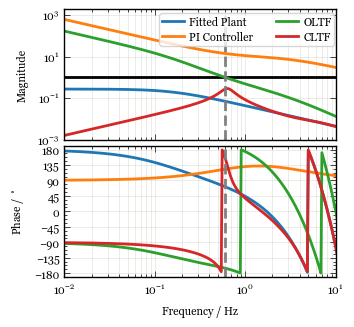

In [34]:
AfracKp = -10
AfracTi=0.253
Afracsmooth_tau=0.05
ff, plant_TF, PID_TF, OLTF, CLTF, Kp, smooth_tau, Ti, Td, UGF, PSF, gain_margin, phase_margin, delay_margin = loop_stability(
    plant_tau=fit_vals['35853']['tau'],
    plant_K=fit_vals['35853']['K'],
    plant_L=fit_vals['35853']['L'],
    Kp=AfracKp,
    Ti=AfracTi,
    Td=0,
    smooth_tau=Afracsmooth_tau
)
fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.05},
                      figsize=(3.5, 3.475))
ax[0].loglog(ff, np.ones_like(ff), label=None, color='k')
ax[0].loglog(ff, np.abs(plant_TF), label='Fitted Plant')
ax[0].loglog(ff, np.abs(PID_TF), label='PI Controller')
ax[0].loglog(ff, np.abs(OLTF), label='OLTF') # label='Open-loop Transfer Function')
ax[0].loglog(ff, np.abs(CLTF), label='CLTF') # label='Closed-loop Transfer Function')
ax[0].set_ylim(1e-3, 2e3)
ax[0].vlines(UGF, 1e-3, 1e3, color='grey', ls='--')
ax[1].semilogx(ff, np.angle(plant_TF, deg=True), label='Fitted Plant')
ax[1].semilogx(ff, np.angle(PID_TF, deg=True), label='PI Controller')
ax[1].semilogx(ff, np.angle(OLTF, deg=True), label='Open-loop Transfer Function')
ax[1].semilogx(ff, np.angle(CLTF, deg=True), label='Closed-loop Transfer Function')
ax[1].set_ylim(-190, 190)
ax[1].vlines(UGF, -190, 190, color='grey', ls='--')
ax[1].set_yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
# ax[1].legend(ncol=2, fontsize=7, loc=(.02, 1.0))
ax[0].legend(ncol=2, loc=(0.35, 0.72))
ax[1].set_xlim(1e-2, 1e1)
ax[1].set_xlabel('Frequency / Hz')
ax[0].set_ylabel('Magnitude')
ax[1].set_ylabel('Phase / ' + r'$^\circ$')
ax[1].yaxis.grid(False, which='minor')

# with open('Afrac_CLTF_values.tex', 'w') as f:
#     f.write(r'\newcommand{\AfracKp}{K$_p$ = ' + f'{AfracKp:.1f}' + '}\n')
#     f.write(r'\newcommand{\AfracTi}{T$_i$ = ' + f'{AfracTi*1e3:.1f}' + ' ms}\n')
#     f.write(r'\newcommand{\Afracstau}{$\tau_s$ = ' + f'{Afracsmooth_tau*1e3:.1f}' + ' ms}\n')
#     f.write(r'\newcommand{\AfracUGF}{' + f'{UGF:.2f}' + ' Hz}\n')
#     f.write(r'\newcommand{\AfracPhaseMargin}{' + f'{phase_margin:.1f}' + ' $^\circ$}\n')
#     f.write(r'\newcommand{\AfracDelayMargin}{' + f'{delay_margin*1e3:.0f}' + ' ms}\n')

# fig.savefig(f'../figures/Afrac_LoopStability.pdf', bbox_inches='tight')

In [35]:
Kp = -10
Td = 0.0
Ti = 0.253
PID_only = ct.tf([Kp * Td * Ti, Kp * Ti, Kp], [Ti, 0])

PID_only

TransferFunction(array([ -2.53, -10.  ]), array([0.253, 0.   ]))

In [36]:
smooth_tau = 0.05
PID_presmooth = ct.tf([1 / smooth_tau], [1, 1 / smooth_tau])
PID_presmooth

TransferFunction(array([20.]), array([ 1., 20.]))

In [37]:
PID = ct.series(PID_presmooth, PID_only)
PID

TransferFunction(array([ -50.6, -200. ]), array([0.253, 5.06 , 0.   ]))

### Surrogate Model SysID

In [38]:
fit_vals['35854'] = fit_shot('35854', '\\SMSQODMAX', '\\GVSPVBLN2',
                            tlims=(7.5, 14), pre_ext=0,
                            bounds=([-np.inf, 0, 0], [np.inf, 1, 1.1]), pade_order=20,)
fit_vals['35854']

{'K': np.float64(-0.302315863617747),
 'Kmin': np.float64(-0.3066837031609574),
 'Kmax': np.float64(-0.2979480240745366),
 'Kstep': np.float64(0.00021839197716052027),
 'tau': np.float64(0.31349186968145476),
 'taumin': np.float64(0.2810376357592784),
 'taumax': np.float64(0.3459461036036311),
 'taustep': np.float64(0.0016227116961088166),
 'L': np.float64(0.5359682600456669),
 'Lmin': np.float64(0.5168840967750707),
 'Lmax': np.float64(0.555052423316263),
 'Lstep': np.float64(0.0009542081635298069),
 'fit_tt': array([ 7.5  ,  7.501,  7.502, ..., 13.997, 13.998, 13.999], shape=(6500,)),
 'fit_yy': array([6.17480564, 6.17480564, 6.17480564, ..., 5.40447849, 5.4040435 ,
        5.40360989], shape=(6500,)),
 'popt': array([-0.30231586,  0.31349187,  0.53596826]),
 'perr': array([0.00436784, 0.03245423, 0.01908416]),
 'pcov': array([[ 1.90780223e-05, -5.19855217e-05,  4.70872913e-06],
        [-5.19855217e-05,  1.05327730e-03, -4.37381755e-04],
        [ 4.70872913e-06, -4.37381755e-04,  3

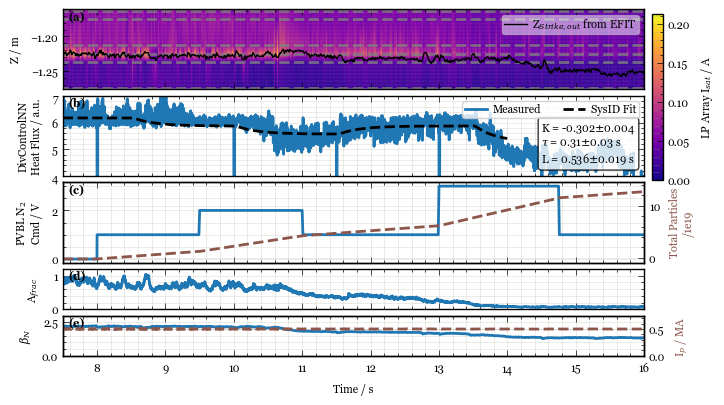

In [44]:
sn = '35854'
vmin = 0.0
vmax = 0.20
starttime = 7.5
colormap = cm.plasma

fig, axs = plt.subplots(5, 1, sharex=True, gridspec_kw={'hspace': 0.1, 'height_ratios':[1.0, 1.0, 1.0, 0.5, 0.5]},
                    figsize=(7.5, 4.5))
ax = axs[0]
axSM = axs[1]
axN2 = axs[2]
axafrac = axs[3]
axbeta = axs[4]

with h5py.File(data_filename, 'r') as h5:
    axafrac.plot(*ch(h5, sn, 'PCS_KSTAR', '\\DVSAFRAC'))
    axSM.plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSQODMAX'), label='Measured')
    axSM.plot(fit_vals[sn]['fit_tt'], fit_vals[sn]['fit_yy'],
                 label='SysID Fit', color='black', ls='--')

    axN2.plot(*clip_flow(h5, sn, 'L', 'N2'))
    caxN2 = axN2.twinx()
    caxN2.plot(*cum_flow(h5, sn, 'L', 'N2'), ls='--', color='tab:brown')

    axbeta.plot(h5[sn]['PCS_KSTAR']['\\EFSBETAN']['dim0'][:],
            h5[sn]['PCS_KSTAR']['\\EFSBETAN']['data'][:],)
    axip = axbeta.twinx()

    axip.plot(h5[sn]['PCS_KSTAR']['\\DVSIP']['dim0'][:],
                -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][:], ls='--', color='tab:brown')
    
    tt = h5[sn]['PCS_KSTAR']['\\PCLPEP51']['dim0'][:]
    LPdata = get_LP_data(h5, sn, LPFsos)
    
    LPz_arr = np.linspace(min(LPz), max(LPz), 100)
    # LPcs = interpolate.CubicSpline(LPz, LPdata, axis=0, bc_type='natural')
    # LPplot = ax.pcolor(tt[::20], LPz_arr, LPcs(LPz_arr)[:, ::20], cmap=colormap, shading='nearest', vmin=vmin, vmax=vmax, label=None, edgecolor='face')
    LP_lin = np.zeros((len(LPz_arr), len(tt)))
    for ii in range(len(tt)):
        LP_lin[:, ii] = np.interp(LPz_arr, LPz, LPdata[:, ii])
    LPplot = ax.pcolor(tt[::20], LPz_arr, LP_lin[:, ::20], cmap=colormap, shading='nearest',
                       vmin=0,
                       vmax=np.max(LP_lin[:, tt>starttime]),
                       label=None, edgecolor='face')

    ax.hlines(LPz, color='grey', ls='--', xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], alpha=0.8,)
    
    try:
        ax.plot(h5[sn]['EFIT01']['\\ZVSOUT']['dim0'][:],
                h5[sn]['EFIT01']['\\ZVSOUT']['data'][:],
                color='black',
                linewidth=1,
                label='Z' + r'$_{Strike, out}$' + ' from EFIT')
    except BaseException:
        pass
    
    for ii in range(len(tt)):
        if tt[ii] > starttime and  -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][ii] < 0.4:
            endtime = tt[ii]
            # print(endtime)
            break

fitK = fit_vals[sn]['K'][()]
fitKerr = fit_vals[sn]['perr'][0][()]
fittau = fit_vals[sn]['tau'][()]
fittauerr = fit_vals[sn]['perr'][1][()]
fitL = fit_vals[sn]['L'][()]
fitLerr = fit_vals[sn]['perr'][2][()]
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
axSM.text(14.5, 4.5, f'K = {fitK:0.3f}' + r'$\pm$' + f'{fitKerr:0.3f}\n'
                + r'$\tau$' + f' = {fittau:0.2f}' + r'$\pm$' + f'{fittauerr:0.2f}' + ' s\n'
                + f'L = {fitL:0.3f}' + r'$\pm$' + f'{fitLerr:0.3f} s',
            bbox=props)

# with open('Afrac_SysID_values.tex', 'w') as f:
#     f.write(r'\newcommand{\AfracK}{' + f'K = {fitK:0.3f}' + r'$\pm$' + f'{fitKerr:0.3f}' + '}\n')
#     f.write(r'\newcommand{\AfracTau}{' + r'$\tau$' + f' = {fittau:0.2f}' + r'$\pm$' + f'{fittauerr:0.2f}' + 's}\n')
#     f.write(r'\newcommand{\AfracL}{' + f'L = {fitL:0.3f}' + r'$\pm$' + f'{fitLerr:0.3f}' + 's}\n')
    
caxl = fig.add_axes([0.91, 0.5, 0.015, 0.37])
fig.colorbar(LPplot, cax = caxl, label='LP Array I' + r'$_{sat}$' + ' / A')

ax.set_ylim(min(LPz)-0.002, max(LPz)+0.002)

axSM.set_ylim(4., 7.0)
axafrac.set_ylim(-0., 1.2)
# caxN2.set_ylim(-1, 6)
axbeta.set_ylim(0, 3.0)
axip.set_ylim(0, 0.75)

ax.set_ylabel('Z / m')
axSM.set_ylabel('DivControlNN\nHeat Flux / a.u.')
axafrac.set_ylabel('A' + '$_{frac}$')
axN2.set_ylabel(r'PVBL N$_2$' + '\nCmd / V')
# axN2.set_ylabel(r'PVBL Ne' + '\nCmd / V')
caxN2.set_ylabel('Total Particles\n/1e19', color='tab:brown')
axbeta.set_ylabel(r'$\beta_N$')
axip.set_ylabel('I' + r'$_p$' + ' / MA', color='tab:brown')



axs[-1].set_xlabel('Time / s')

endtime=16.0
axs[-1].set_xlim((starttime, endtime))

ax.legend(
    # loc=(0.6, 0.05), 
    loc='upper right',
    framealpha=0.5)
axSM.legend(ncols=2,
            #    loc=(0.6, 0.75),
               loc='upper right',
)

add_subplot_ind(ax, 0.01, '(a)')
add_subplot_ind(axSM, 0.01, '(b)')
add_subplot_ind(axN2, 0.01, '(c)')
add_subplot_ind(axafrac, 0.01, '(d)')
add_subplot_ind(axbeta, 0.01, '(e)')

ax.grid(False, 'both')
caxN2.yaxis.grid(False, which='minor')
axip.yaxis.grid(False, which='minor')

fig.savefig(f'../figures/DetCtrl_2D_{sn}.pdf', bbox_inches='tight')

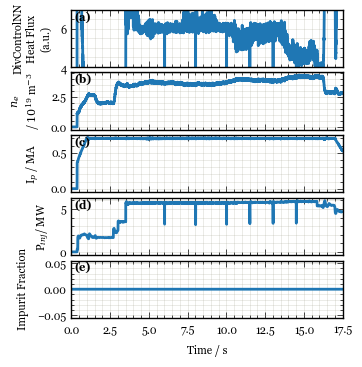

In [45]:
sn = '35854'

starttime = 0
endtime = 17.5


fig, axs = plt.subplots(5, 1, sharex=True, gridspec_kw={'hspace': 0.1, 'height_ratios':[1.0, 1.0, 1.0, 1.0, 1.0]},
                    figsize=(3.5, 4.0))
axhf = axs[0]
axne = axs[1]
axIp = axs[2]
axPinj = axs[3]
axImpFrac = axs[4]

with h5py.File(data_filename, 'r') as h5:
    axhf.plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSQODMAX'))
    axne.plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSDENSITYIN'))
    axIp.plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSIPIN'))
    axPinj.plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSPOWERIN'))
    axImpFrac.plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSIMPFRACIN'))

axhf.set_ylabel('DivControlNN\nHeat Flux\n(a.u.)')
axne.set_ylabel(r'$n_e$' + '\n/ '+ r'$10^{19}$' + ' m'+ r'$^{-3}$')
axIp.set_ylabel('I' + r'$_p$' + ' / MA')
axPinj.set_ylabel('P' + r'$_{inj}$' + '/ MW')
axImpFrac.set_ylabel('Impurit Fraction')
axs[-1].set_xlabel('Time / s')

axhf.set_ylim(4.0, 7.0)

axs[-1].set_xlim(starttime, endtime)

add_subplot_ind(axhf, 0.01, '(a)')
add_subplot_ind(axne, 0.01, '(b)')
add_subplot_ind(axIp, 0.01, '(c)')
add_subplot_ind(axPinj, 0.01, '(d)')
add_subplot_ind(axImpFrac, 0.01, '(e)')

# fig.savefig(f'../figures/SM_inputs_{sn}.pdf', bbox_inches='tight')

For 36161:

SMKp = -3
SMTi = 0.0685
SMsmooth_tau = 0.005

For 36162:



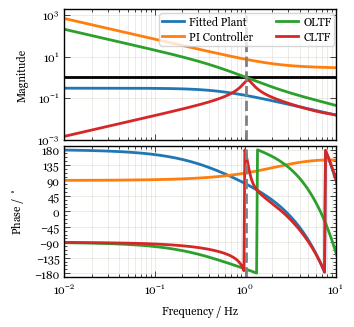

In [46]:
SMKp = -3
SMTi=0.0685
SMsmooth_tau=0.005
ff, plant_TF, PID_TF, OLTF, CLTF, Kp, smooth_tau, Ti, Td, UGF, PSF, gain_margin, phase_margin, delay_margin = loop_stability(
    plant_tau=fit_vals['35854']['tau'],
    plant_K=fit_vals['35854']['K'],
    plant_L=0.1, #fit_vals['35853']['L'],
    Kp=SMKp,
    Ti=SMTi,
    Td=0,
    smooth_tau=SMsmooth_tau
)
fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0.05},
                      figsize=(3.5, 3.475))
ax[0].loglog(ff, np.ones_like(ff), label=None, color='k')
ax[0].loglog(ff, np.abs(plant_TF), label='Fitted Plant')
ax[0].loglog(ff, np.abs(PID_TF), label='PI Controller')
ax[0].loglog(ff, np.abs(OLTF), label='OLTF') # label='Open-loop Transfer Function')
ax[0].loglog(ff, np.abs(CLTF), label='CLTF') # label='Closed-loop Transfer Function')
ax[0].set_ylim(1e-3, 2e3)
ax[0].vlines(UGF, 1e-3, 1e3, color='grey', ls='--')
ax[1].semilogx(ff, np.angle(plant_TF, deg=True), label='Fitted Plant')
ax[1].semilogx(ff, np.angle(PID_TF, deg=True), label='PI Controller')
ax[1].semilogx(ff, np.angle(OLTF, deg=True), label='Open-loop Transfer Function')
ax[1].semilogx(ff, np.angle(CLTF, deg=True), label='Closed-loop Transfer Function')
ax[1].set_ylim(-190, 190)
ax[1].vlines(UGF, -190, 190, color='grey', ls='--')
ax[1].set_yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
# ax[1].legend(ncol=2, fontsize=7, loc=(.02, 1.0))
ax[0].legend(ncol=2, loc=(0.35, 0.72))
ax[1].set_xlim(1e-2, 1e1)
ax[1].set_xlabel('Frequency / Hz')
ax[0].set_ylabel('Magnitude')
ax[1].set_ylabel('Phase / ' + r'$^\circ$')
ax[1].yaxis.grid(False, which='minor')

# with open('SM_CLTF_values.tex', 'w') as f:
#     f.write(r'\newcommand{\SMKp}{K$_p$ = ' + f'{SMKp:.1f}' + '}\n')
#     f.write(r'\newcommand{\SMTi}{T$_i$ = ' + f'{SMTi*1e3:.1f}' + ' ms}\n')
#     f.write(r'\newcommand{\SMstau}{$\tau_s$ = ' + f'{SMsmooth_tau*1e3:.1f}' + ' ms}\n')
#     f.write(r'\newcommand{\SMUGF}{' + f'{UGF:.2f}' + ' Hz}\n')
#     f.write(r'\newcommand{\SMPhaseMargin}{' + f'{phase_margin:.1f}' + ' $^\circ$}\n')
#     f.write(r'\newcommand{\SMDelayMargin}{' + f'{delay_margin*1e3:.0f}' + ' ms}\n')

# fig.savefig(f'../figures/SM_LoopStability.pdf', bbox_inches='tight')

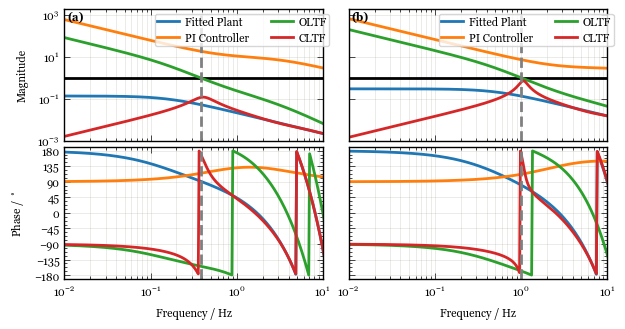

In [47]:
fig, axs = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.05, 'wspace': 0.1},
                        figsize=(7.0, 3.5))

ax = axs[:, 0]
ff, plant_TF, PID_TF, OLTF, CLTF, Kp, smooth_tau, Ti, Td, UGF, PSF, gain_margin, phase_margin, delay_margin = loop_stability(
    plant_tau=fit_vals['35853']['tau'],
    plant_K=fit_vals['35853']['K']/2,
    plant_L=fit_vals['35853']['L'],
    Kp=AfracKp,
    Ti=AfracTi,
    Td=0,
    smooth_tau=Afracsmooth_tau
)
ax[0].loglog(ff, np.ones_like(ff), label=None, color='k')
ax[0].loglog(ff, np.abs(plant_TF), label='Fitted Plant')
ax[0].loglog(ff, np.abs(PID_TF), label='PI Controller')
ax[0].loglog(ff, np.abs(OLTF), label='OLTF') # label='Open-loop Transfer Function')
ax[0].loglog(ff, np.abs(CLTF), label='CLTF') # label='Closed-loop Transfer Function')
ax[0].set_ylim(1e-3, 2e3)
ax[0].vlines(UGF, 1e-3, 1e3, color='grey', ls='--')
ax[1].semilogx(ff, np.angle(plant_TF, deg=True), label='Fitted Plant')
ax[1].semilogx(ff, np.angle(PID_TF, deg=True), label='PI Controller')
ax[1].semilogx(ff, np.angle(OLTF, deg=True), label='Open-loop Transfer Function')
ax[1].semilogx(ff, np.angle(CLTF, deg=True), label='Closed-loop Transfer Function')
ax[1].set_ylim(-190, 190)
ax[1].vlines(UGF, -190, 190, color='grey', ls='--')
ax[1].set_yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
# ax[1].legend(ncol=2, fontsize=7, loc=(.02, 1.0))
ax[0].legend(ncol=2, loc=(0.35, 0.72))
ax[1].set_xlim(1e-2, 1e1)
ax[1].set_xlabel('Frequency / Hz')
ax[0].set_ylabel('Magnitude')
ax[1].set_ylabel('Phase / ' + r'$^\circ$')
ax[1].yaxis.grid(False, which='minor')
add_subplot_ind(ax[0], 0.01, '(a)')

ax = axs[:, 1]
ff, plant_TF, PID_TF, OLTF, CLTF, Kp, smooth_tau, Ti, Td, UGF, PSF, gain_margin, phase_margin, delay_margin = loop_stability(
    plant_tau=fit_vals['35854']['tau'],
    plant_K=fit_vals['35854']['K'],
    plant_L=0.1, #fit_vals['35853']['L'],
    Kp=SMKp,
    Ti=SMTi,
    Td=0,
    smooth_tau=SMsmooth_tau
)
ax[0].loglog(ff, np.ones_like(ff), label=None, color='k')
ax[0].loglog(ff, np.abs(plant_TF), label='Fitted Plant')
ax[0].loglog(ff, np.abs(PID_TF), label='PI Controller')
ax[0].loglog(ff, np.abs(OLTF), label='OLTF') # label='Open-loop Transfer Function')
ax[0].loglog(ff, np.abs(CLTF), label='CLTF') # label='Closed-loop Transfer Function')
ax[0].set_ylim(1e-3, 2e3)
ax[0].vlines(UGF, 1e-3, 1e3, color='grey', ls='--')
ax[1].semilogx(ff, np.angle(plant_TF, deg=True), label='Fitted Plant')
ax[1].semilogx(ff, np.angle(PID_TF, deg=True), label='PI Controller')
ax[1].semilogx(ff, np.angle(OLTF, deg=True), label='Open-loop Transfer Function')
ax[1].semilogx(ff, np.angle(CLTF, deg=True), label='Closed-loop Transfer Function')
ax[1].set_ylim(-190, 190)
ax[1].vlines(UGF, -190, 190, color='grey', ls='--')
ax[1].set_yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
# ax[1].legend(ncol=2, fontsize=7, loc=(.02, 1.0))
ax[0].legend(ncol=2, loc=(0.35, 0.72))
ax[1].set_xlim(1e-2, 1e1)
ax[1].set_xlabel('Frequency / Hz')
# ax[0].set_ylabel('Magnitude')
# ax[1].set_ylabel('Phase / ' + r'$^\circ$')
ax[0].set_yticklabels([])
ax[1].set_yticklabels([])
ax[1].yaxis.grid(False, which='minor')
add_subplot_ind(ax[0], 0.01, '(b)')

# fig.savefig("../figures/Loop_Stability_Joined.pdf", bbox_inches='tight')

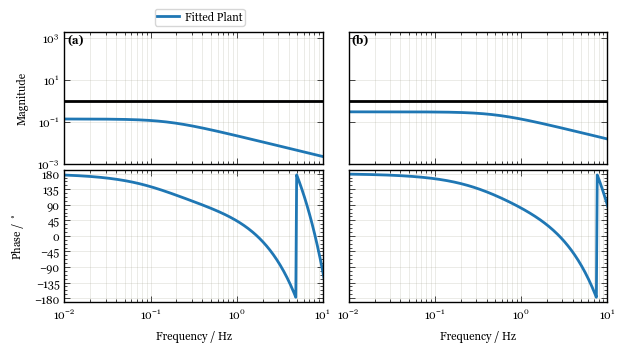

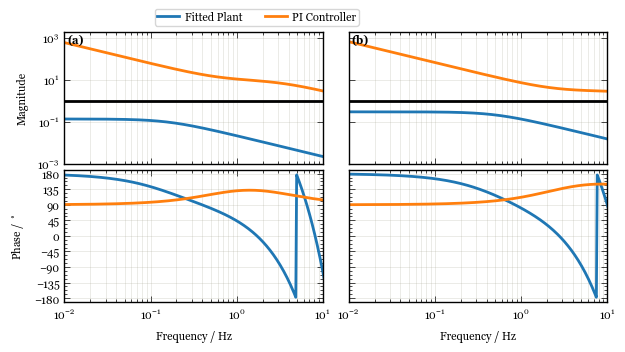

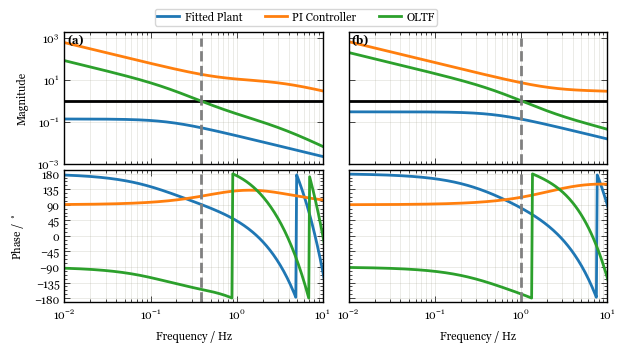

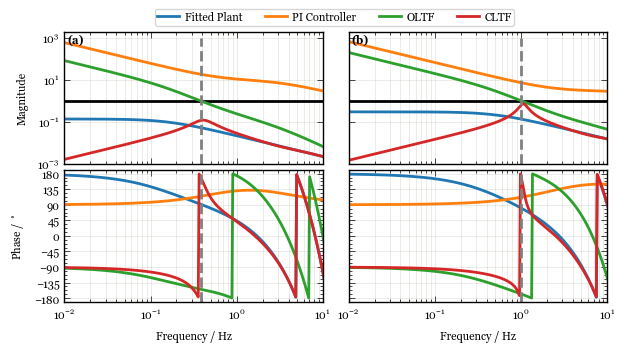

In [48]:
for ti in range(1, 5):
    fig, axs = plt.subplots(2, 2, sharex=True, gridspec_kw={'hspace': 0.05, 'wspace': 0.1},
                            figsize=(7.0, 3.5))
    ax = axs[:, 0]
    ff, plant_TF, PID_TF, OLTF, CLTF, Kp, smooth_tau, Ti, Td, UGF, PSF, gain_margin, phase_margin, delay_margin = loop_stability(
        plant_tau=fit_vals['35853']['tau'],
        plant_K=fit_vals['35853']['K']/2,
        plant_L=fit_vals['35853']['L'],
        Kp=AfracKp,
        Ti=AfracTi,
        Td=0,
        smooth_tau=Afracsmooth_tau
    )
    ax[0].loglog(ff, np.ones_like(ff), label=None, color='k')
    if ti >= 1:
        ax[0].loglog(ff, np.abs(plant_TF), label='Fitted Plant')
    if ti >= 2:
        ax[0].loglog(ff, np.abs(PID_TF), label='PI Controller')
    if ti >= 3:
        ax[0].loglog(ff, np.abs(OLTF), label='OLTF') # label='Open-loop Transfer Function')
    if ti >= 4:
        ax[0].loglog(ff, np.abs(CLTF), label='CLTF') # label='Closed-loop Transfer Function')
    ax[0].set_ylim(1e-3, 2e3)
    if ti >= 3:
        ax[0].vlines(UGF, 1e-3, 1e3, color='grey', ls='--')
    if ti >= 1:
        ax[1].semilogx(ff, np.angle(plant_TF, deg=True), label='Fitted Plant')
    if ti >= 2:
        ax[1].semilogx(ff, np.angle(PID_TF, deg=True), label='PI Controller')
    if ti >= 3:
        ax[1].semilogx(ff, np.angle(OLTF, deg=True), label='Open-loop Transfer Function')
    if ti >= 4:
        ax[1].semilogx(ff, np.angle(CLTF, deg=True), label='Closed-loop Transfer Function')
    ax[1].set_ylim(-190, 190)
    if ti >= 3:
        ax[1].vlines(UGF, -190, 190, color='grey', ls='--')
    ax[1].set_yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
    # ax[1].legend(ncol=2, fontsize=7, loc=(.02, 1.0))
    # ax[0].legend(ncol=2, loc=(0.35, 0.72))
    ax[1].set_xlim(1e-2, 1e1)
    ax[1].set_xlabel('Frequency / Hz')
    ax[0].set_ylabel('Magnitude')
    ax[1].set_ylabel('Phase / ' + r'$^\circ$')
    ax[1].yaxis.grid(False, which='minor')
    add_subplot_ind(ax[0], 0.01, '(a)')

    ax = axs[:, 1]
    ff, plant_TF, PID_TF, OLTF, CLTF, Kp, smooth_tau, Ti, Td, UGF, PSF, gain_margin, phase_margin, delay_margin = loop_stability(
        plant_tau=fit_vals['35854']['tau'],
        plant_K=fit_vals['35854']['K'],
        plant_L=0.1, #fit_vals['35853']['L'],
        Kp=SMKp,
        Ti=SMTi,
        Td=0,
        smooth_tau=SMsmooth_tau
    )
    ax[0].loglog(ff, np.ones_like(ff), label=None, color='k')
    if ti >= 1:
        ax[0].loglog(ff, np.abs(plant_TF), label='Fitted Plant')
    if ti >= 2:
        ax[0].loglog(ff, np.abs(PID_TF), label='PI Controller')
    if ti >= 3:
        ax[0].loglog(ff, np.abs(OLTF), label='OLTF') # label='Open-loop Transfer Function')
    if ti >= 4:
        ax[0].loglog(ff, np.abs(CLTF), label='CLTF') # label='Closed-loop Transfer Function')
    ax[0].set_ylim(1e-3, 2e3)
    if ti >= 3:
        ax[0].vlines(UGF, 1e-3, 1e3, color='grey', ls='--')
    if ti >= 1:
        ax[1].semilogx(ff, np.angle(plant_TF, deg=True), label='Fitted Plant')
    if ti >= 2:
        ax[1].semilogx(ff, np.angle(PID_TF, deg=True), label='PI Controller')
    if ti >= 3:
        ax[1].semilogx(ff, np.angle(OLTF, deg=True), label='Open-loop Transfer Function')
    if ti >= 4:
        ax[1].semilogx(ff, np.angle(CLTF, deg=True), label='Closed-loop Transfer Function')
    ax[1].set_ylim(-190, 190)
    if ti >= 3:
        ax[1].vlines(UGF, -190, 190, color='grey', ls='--')
    ax[1].set_yticks([-180, -135, -90, -45, 0, 45, 90, 135, 180])
    # ax[1].legend(ncol=2, fontsize=7, loc=(.02, 1.0))
    ax[0].legend(ncol=4, loc=(-0.75, 1.05))
    ax[1].set_xlim(1e-2, 1e1)
    ax[1].set_xlabel('Frequency / Hz')
    # ax[0].set_ylabel('Magnitude')
    # ax[1].set_ylabel('Phase / ' + r'$^\circ$')
    ax[0].set_yticklabels([])
    ax[1].set_yticklabels([])
    ax[1].yaxis.grid(False, which='minor')
    add_subplot_ind(ax[0], 0.01, '(b)')

    # fig.savefig(f"../figures/Loop_Stability_Joined_t{ti}.pdf", bbox_inches='tight')

## Results

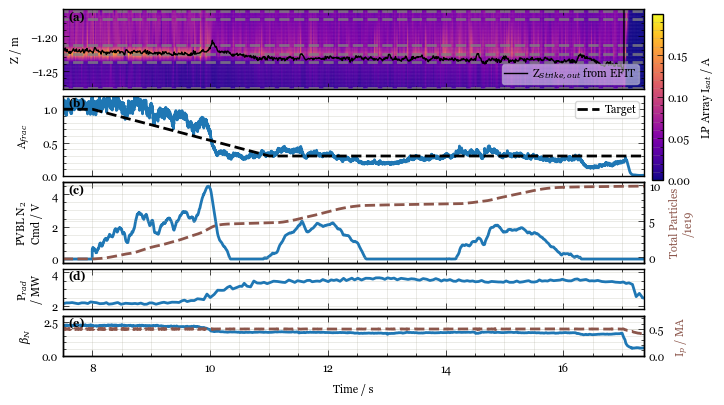

In [49]:
sn = '35857'
vmin = 0.0
vmax = 0.2
starttime = 7.5
colormap = cm.plasma


fig, axs = plt.subplots(5, 1, sharex=True, gridspec_kw={'hspace': 0.1, 'height_ratios':[1.0, 1.0, 1.0, 0.5, 0.5]},
                    figsize=(7.5, 4.5))
ax = axs[0]
axafrac = axs[1]
axN2 = axs[2]
axprad = axs[3]
axbeta = axs[4]
with h5py.File(data_filename, 'r') as h5:
    axafrac.plot(*ch(h5, sn, 'PCS_KSTAR', '\\DVSAFRAC'))
    axafrac.plot(*ch(h5, sn, 'PCS_KSTAR','\\DVTAFRAC'),
                 color='black', label='Target', ls='--')

    axN2.plot(*clip_flow(h5, sn, 'L', 'N2'))
    caxN2 = axN2.twinx()
    caxN2.plot(*cum_flow(h5, sn, 'L', 'N2'), ls='--', color='tab:brown')

    axprad.plot(*ch(h5, sn, 'KSTAR', '\\IRVB1_PRAD'))

    axbeta.plot(h5[sn]['PCS_KSTAR']['\\EFSBETAN']['dim0'][:],
            h5[sn]['PCS_KSTAR']['\\EFSBETAN']['data'][:],)
    axip = axbeta.twinx()

    axip.plot(h5[sn]['PCS_KSTAR']['\\DVSIP']['dim0'][:],
                -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][:], ls='--', color='tab:brown')
    
    tt = h5[sn]['PCS_KSTAR']['\\PCLPEP51']['dim0'][:]
    LPdata = get_LP_data(h5, sn, LPFsos)
    
    LPz_arr = np.linspace(min(LPz), max(LPz), 100)
    # LPcs = interpolate.CubicSpline(LPz, LPdata, axis=0, bc_type='natural')
    # LPplot = ax.pcolor(tt[::20], LPz_arr, LPcs(LPz_arr)[:, ::20], cmap=colormap, shading='nearest', vmin=vmin, vmax=vmax, label=None, edgecolor='face')
    LP_lin = np.zeros((len(LPz_arr), len(tt)))
    for ii in range(len(tt)):
        LP_lin[:, ii] = np.interp(LPz_arr, LPz, LPdata[:, ii])
    LPplot = ax.pcolor(tt[::20], LPz_arr, LP_lin[:, ::20], cmap=colormap, shading='nearest',
                       vmin=0,
                       vmax=np.max(LP_lin[:, tt>starttime]),
                       label=None, edgecolor='face')

    ax.hlines(LPz, color='grey', ls='--', xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], alpha=0.8)

    try:
        ax.plot(h5[sn]['EFIT01']['\\ZVSOUT']['dim0'][:],
                h5[sn]['EFIT01']['\\ZVSOUT']['data'][:],
                color='black',
                linewidth=1,
                label='Z' + r'$_{Strike, out}$' + ' from EFIT')
    except BaseException:
        pass
    
    for ii in range(len(tt)):
        if tt[ii] > starttime and  -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][ii] < 0.4:
            endtime = tt[ii]
            # print(endtime)
            break

caxl = fig.add_axes([0.91, 0.5, 0.015, 0.37])
fig.colorbar(LPplot, cax = caxl, label='LP Array I' + r'$_{sat}$' + ' / A')

ax.set_ylim(min(LPz)-0.002, max(LPz)+0.002)
axafrac.set_ylim(-0., 1.2)
# caxN2.set_ylim(-1, 6)
axprad.set_ylim(1.8, 4.2)
axbeta.set_ylim(0, 3.0)
axip.set_ylim(0, 0.75)

ax.set_ylabel('Z / m')
axafrac.set_ylabel('A' + '$_{frac}$')
axN2.set_ylabel(r'PVBL N$_2$' + '\nCmd / V')
caxN2.set_ylabel('Total Particles\n/1e19', color='tab:brown')
axprad.set_ylabel('P' + '$_{rad}$\n/ MW')
axbeta.set_ylabel(r'$\beta_N$')
axip.set_ylabel('I' + r'$_p$' + ' / MA', color='tab:brown')

ax.legend(
    # loc=(0.6, 0.05), 
    loc='lower right',
    framealpha=0.5)
axafrac.legend(ncols=2,
            #    loc=(0.6, 0.75),
               loc='upper right',
)

axs[-1].set_xlabel('Time / s')

axs[-1].set_xlim((starttime, endtime))

add_subplot_ind(ax, 0.01, '(a)')
add_subplot_ind(axafrac, 0.01, '(b)')
add_subplot_ind(axN2, 0.01, '(c)')
add_subplot_ind(axprad, 0.01, '(d)')
add_subplot_ind(axbeta, 0.01, '(e)')

ax.grid(False, 'both')
caxN2.yaxis.grid(False, which='minor')
axip.yaxis.grid(False, which='minor')

fig.savefig(f'../figures/DetCtrl_2D_{sn}.pdf', bbox_inches='tight')

/var/folders/hb/_qb1q5r90qj02zv4c0yzxg5w0000gq/T/ipykernel_57009/1015596059.py:7: RuntimeWarning: divide by zero encountered in divide
  ch(h5, sn, 'KSTAR', '\\IRVB1_PRAD')[1] / ch(h5, sn, 'PCS_KSTAR', '\\SMSPOWERIN')[1])
/var/folders/hb/_qb1q5r90qj02zv4c0yzxg5w0000gq/T/ipykernel_57009/1015596059.py:7: RuntimeWarning: invalid value encountered in divide
  ch(h5, sn, 'KSTAR', '\\IRVB1_PRAD')[1] / ch(h5, sn, 'PCS_KSTAR', '\\SMSPOWERIN')[1])


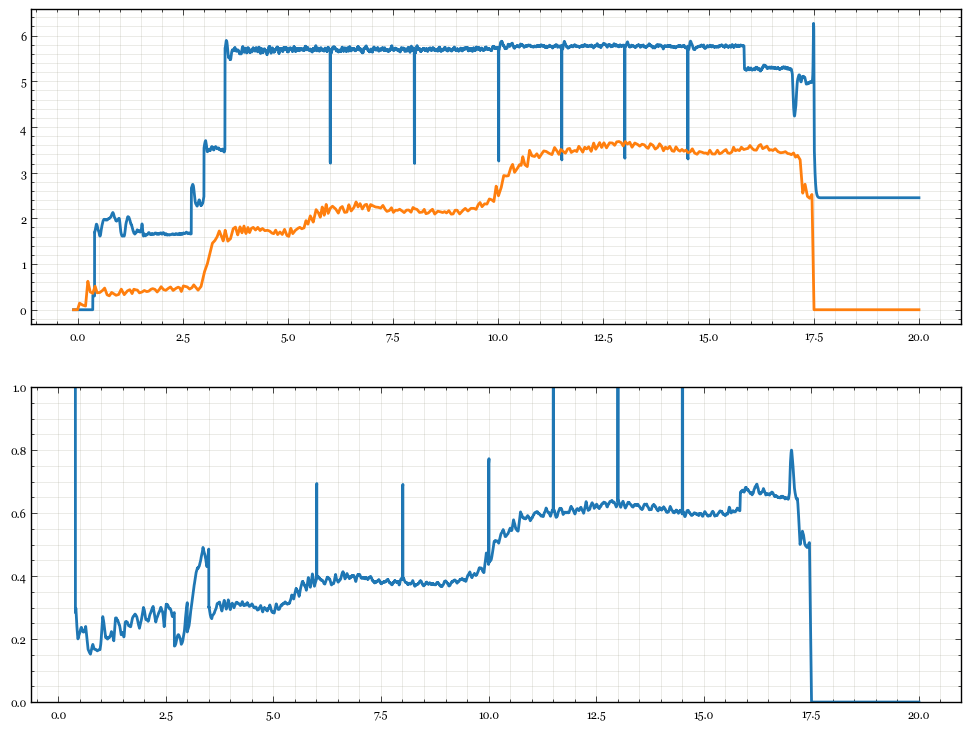

In [50]:
sn = '35857'
fig, ax = plt.subplots(2, 1)
with h5py.File(data_filename, 'r') as h5:
    ax[0].plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSPOWERIN'))
    ax[0].plot(*ch(h5, sn, 'KSTAR', '\\IRVB1_PRAD'))
    ax[1].plot(ch(h5, sn, 'PCS_KSTAR', '\\SMSPOWERIN')[0],
               ch(h5, sn, 'KSTAR', '\\IRVB1_PRAD')[1] / ch(h5, sn, 'PCS_KSTAR', '\\SMSPOWERIN')[1])
    ax[1].set_ylim(0, 1)

/var/folders/hb/_qb1q5r90qj02zv4c0yzxg5w0000gq/T/ipykernel_57009/823918155.py:12: RuntimeWarning: divide by zero encountered in divide
  ch(h5, sn, 'KSTAR', '\\IRVB1_PRAD')[1] / ch(h5, sn, 'PCS_KSTAR', '\\SMSPOWERIN')[1],
/var/folders/hb/_qb1q5r90qj02zv4c0yzxg5w0000gq/T/ipykernel_57009/823918155.py:12: RuntimeWarning: invalid value encountered in divide
  ch(h5, sn, 'KSTAR', '\\IRVB1_PRAD')[1] / ch(h5, sn, 'PCS_KSTAR', '\\SMSPOWERIN')[1],


Text(0.5, 1.0, 'KSTAR #36161')

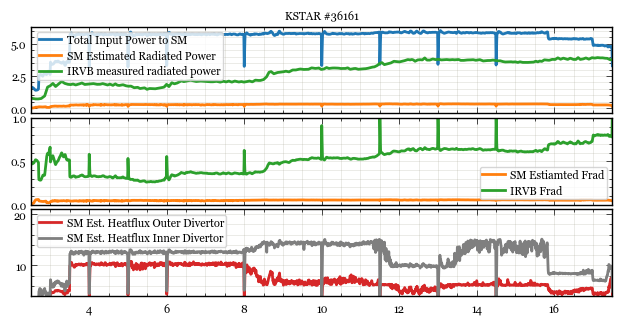

In [51]:
sn = '36161'
fig, ax = plt.subplots(3, 1, figsize=(7.5, 3.5), sharex=True, gridspec_kw={'hspace': 0.05})
with h5py.File(data_filename, 'r') as h5:
    ax[0].plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSPOWERIN'), label='Total Input Power to SM')
    ax[0].plot(ch(h5, sn, 'PCS_KSTAR', '\\SMSPOWERIN')[0],
               ch(h5, sn, 'PCS_KSTAR', '\\SMSPOWERIN')[1] * ch(h5, sn, 'PCS_KSTAR', '\\SMSFRADTOT')[1],
               label='SM Estimated Radiated Power')
    # 
    ax[0].plot(*ch(h5, sn, 'KSTAR', '\\IRVB1_PRAD'), label='IRVB measured radiated power')
    ax[1].plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSFRADTOT'), label='SM Estiamted Frad', color='tab:orange')
    ax[1].plot(ch(h5, sn, 'PCS_KSTAR', '\\SMSPOWERIN')[0],
               ch(h5, sn, 'KSTAR', '\\IRVB1_PRAD')[1] / ch(h5, sn, 'PCS_KSTAR', '\\SMSPOWERIN')[1],
               label='IRVB Frad', color='tab:green')
    ax[2].plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSQODMAX'), label='SM Est. Heatflux Outer Divertor',
               color='tab:red')
    ax[2].plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSQIDMAX'), label='SM Est. Heatflux Inner Divertor',
               color='tab:grey')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

ax[1].set_ylim(0, 1)
ax[2].set_ylim(4, 21)
ax[2].set_xlim(2.5, 17.5)
ax[0].set_title(f'KSTAR #{sn}')

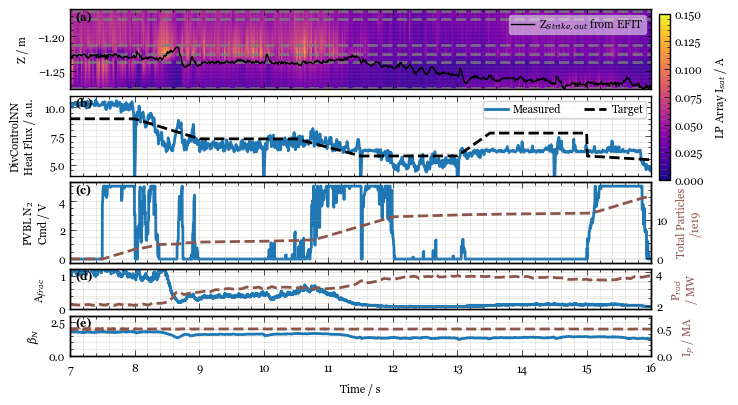

In [ ]:
sn = '36161'
vmin = 0.0
vmax = 0.15
starttime = 7.0
colormap = cm.plasma

fig, axs = plt.subplots(5, 1, sharex=True, gridspec_kw={'hspace': 0.1, 'height_ratios':[1.0, 1.0, 1.0, 0.5, 0.5]},
                    figsize=(7.5, 4.5))
ax = axs[0]
axSM = axs[1]
axN2 = axs[2]
axafrac = axs[3]
axbeta = axs[4]

with h5py.File(data_filename, 'r') as h5:
    axafrac.plot(*ch(h5, sn, 'PCS_KSTAR', '\\DVSAFRAC'))
    axSM.plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSQODMAX'), label='Measured')
    axSM.plot(*ch(h5, sn, 'PCS_KSTAR', '\\DVTSMQOD'), label='Target', color='black', ls='--')

    axN2.plot(*clip_flow(h5, sn, 'L', 'N2'))
    caxN2 = axN2.twinx()
    caxN2.plot(*cum_flow(h5, sn, 'L', 'N2'), ls='--', color='tab:brown')

    axbeta.plot(h5[sn]['PCS_KSTAR']['\\EFSBETAN']['dim0'][:],
            h5[sn]['PCS_KSTAR']['\\EFSBETAN']['data'][:],)
    axip = axbeta.twinx()

    axip.plot(h5[sn]['PCS_KSTAR']['\\DVSIP']['dim0'][:],
                -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][:], ls='--', color='tab:brown')
    
    tt = h5[sn]['PCS_KSTAR']['\\PCLPEP51']['dim0'][:]
    LPdata = get_LP_data(h5, sn, LPFsos)
    
    LPz_arr = np.linspace(min(LPz), max(LPz), 100)
    # LPcs = interpolate.CubicSpline(LPz, LPdata, axis=0, bc_type='natural')
    # LPplot = ax.pcolor(tt[::20], LPz_arr, LPcs(LPz_arr)[:, ::20], cmap=colormap, shading='nearest', vmin=vmin, vmax=vmax, label=None, edgecolor='face')
    LP_lin = np.zeros((len(LPz_arr), len(tt)))
    for ii in range(len(tt)):
        LP_lin[:, ii] = np.interp(LPz_arr, LPz, LPdata[:, ii])
    LPplot = ax.pcolor(tt[::20], LPz_arr, LP_lin[:, ::20], cmap=colormap, shading='nearest',
                       vmin=0,
                       vmax=np.max(LP_lin[:, tt>starttime]),
                       label=None, edgecolor='face')

    ax.hlines(LPz, color='grey', ls='--', xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], alpha=0.8,)
    
    try:
        ax.plot(h5[sn]['EFIT01']['\\ZVSOUT']['dim0'][:],
                h5[sn]['EFIT01']['\\ZVSOUT']['data'][:],
                color='black',
                linewidth=1,
                label='Z' + r'$_{Strike, out}$' + ' from EFIT')
    except BaseException:
        pass
    
    for ii in range(len(tt)):
        if tt[ii] > starttime and  -h5[sn]['PCS_KSTAR']['\\DVSIP']['data'][ii] < 0.4:
            endtime = tt[ii]
            # print(endtime)
            break
    
    axprad = axafrac.twinx()
    axprad.plot(*ch(h5, sn, 'KSTAR', '\\IRVB1_PRAD'), color='tab:brown', ls='--')

caxl = fig.add_axes([0.91, 0.5, 0.015, 0.37])
fig.colorbar(LPplot, cax = caxl, label='LP Array I' + r'$_{sat}$' + ' / A')

ax.set_ylim(min(LPz)-0.002, max(LPz)+0.002)

axSM.set_ylim(4., 11.0)
axafrac.set_ylim(-0., 1.2)
axprad.set_ylim(1.8, 4.2)
# caxN2.set_ylim(-1, 6)
axbeta.set_ylim(0, 3.0)
axip.set_ylim(0, 0.75)

ax.set_ylabel('Z / m')
axSM.set_ylabel('DivControlNN\nHeat Flux / a.u.')
axafrac.set_ylabel('A' + '$_{frac}$')
axprad.set_ylabel('P' + '$_{rad}$\n/ MW', color='tab:brown')
axN2.set_ylabel(r'PVBL N$_2$' + '\nCmd / V')
# axN2.set_ylabel(r'PVBL Ne' + '\nCmd / V')
caxN2.set_ylabel('Total Particles\n/1e19', color='tab:brown')
axbeta.set_ylabel(r'$\beta_N$')
axip.set_ylabel('I' + r'$_p$' + ' / MA', color='tab:brown')



axs[-1].set_xlabel('Time / s')

endtime=16.0
axs[-1].set_xlim((starttime, endtime))

ax.legend(
    # loc=(0.6, 0.05), 
    loc='upper right',
    framealpha=0.5)
axSM.legend(ncols=2,
            #    loc=(0.6, 0.75),
               loc='upper right',
)

add_subplot_ind(ax, 0.01, '(a)')
add_subplot_ind(axSM, 0.01, '(b)')
add_subplot_ind(axN2, 0.01, '(c)')
add_subplot_ind(axafrac, 0.01, '(d)')
add_subplot_ind(axbeta, 0.01, '(e)')

ax.grid(False, 'both')
caxN2.yaxis.grid(False, which='minor')
axip.yaxis.grid(False, which='minor')

# fig.savefig(f'../figures/DetCtrl_2D_{sn}.pdf', bbox_inches='tight')

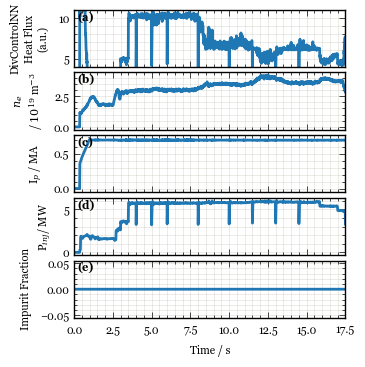

In [53]:
sn = '36161'

starttime = 0
endtime = 17.5


fig, axs = plt.subplots(5, 1, sharex=True, gridspec_kw={'hspace': 0.1, 'height_ratios':[1.0, 1.0, 1.0, 1.0, 1.0]},
                    figsize=(3.5, 4.0))
axhf = axs[0]
axne = axs[1]
axIp = axs[2]
axPinj = axs[3]
axImpFrac = axs[4]

with h5py.File(data_filename, 'r') as h5:
    axhf.plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSQODMAX'))
    axne.plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSDENSITYIN'))
    axIp.plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSIPIN'))
    axPinj.plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSPOWERIN'))
    axImpFrac.plot(*ch(h5, sn, 'PCS_KSTAR', '\\SMSIMPFRACIN'))

axhf.set_ylabel('DivControlNN\nHeat Flux\n(a.u.)')
axne.set_ylabel(r'$n_e$' + '\n/ '+ r'$10^{19}$' + ' m'+ r'$^{-3}$')
axIp.set_ylabel('I' + r'$_p$' + ' / MA')
axPinj.set_ylabel('P' + r'$_{inj}$' + '/ MW')
axImpFrac.set_ylabel('Impurit Fraction')
axs[-1].set_xlabel('Time / s')

axhf.set_ylim(4.0, 11.0)

axs[-1].set_xlim(starttime, endtime)

add_subplot_ind(axhf, 0.01, '(a)')
add_subplot_ind(axne, 0.01, '(b)')
add_subplot_ind(axIp, 0.01, '(c)')
add_subplot_ind(axPinj, 0.01, '(d)')
add_subplot_ind(axImpFrac, 0.01, '(e)')

# fig.savefig(f'../figures/SM_inputs_{sn}.pdf', bbox_inches='tight')

## PID sims

In [ ]:
# int control_matrix_operation(struct ctrl_matrix_input dat) {
#     enum ctrl_matrix_errors {
#         ERR_NO_ERROR = 0,
#         ERR_UNEXPECTED_NON_FINITE = 22
#     };
#     size_t nr = dat.n_row;
#     size_t nc = dat.n_col;

#     #if defined(DEBUG_CONTROL_MATRIX)
#     FILE *f = fopen("control_matrix_include.out", "w");
#     fprintf(f, "CONTROL_MATRIX: nr=%d, nc=%d:",nr, nc);
#     fprintf(f, "P gain matrix:\n     ");
#     for (size_t j=0; j<nc; ++j) {
#         fprintf(f, "%10d", j);
#     }
#     fprintf(f, "\n");
#     for (size_t i=0; i<nr; ++i) {
#         fprintf(f, "%3d: ", i);
#         for (size_t j=0; j<nc; ++j) {
#             fprintf(f, "%10.2e", dat.p_gain_matrix[i * nc + j]);
#         }
#         fprintf(f, "\n");
#     }
#     #endif

#     // Resolve integration allowed per cell
#     enum intallow integration_allowed[nr][nc];
#     for (size_t i=0; i<nr; ++i) {
#         for (size_t j=0; j<nc; ++j) {
#             if (dat.integral_global_override > -1) {
#                 integration_allowed[i][j] = dat.integral_global_override;
#             } else {
#                 // If not overridde, default to following per input behavior
#                 integration_allowed[i][j] = dat.allow_integration_per_input[i];
#                 // unless the column is railed, then restrict to winddown only
#                 bool const restricted = (
#                     (dat.column_railed[j] == COMMAND_RAILED_LOW) ||
#                     (dat.column_railed[j] == COMMAND_RAILED_HIGH)
#                 );
#                 if (restricted && (dat.allow_integration_per_input[i] == INTEGRATION_ALLOWED)) {
#                     integration_allowed[i][j] = INTEGRATION_WINDDOWN_ONLY;
#                 }
#             }
#         }
#     }
#     #if defined(DEBUG_CONTROL_MATRIX)
#         fprintf(f, "column railed=");
#         for (size_t j=0; j<nc; ++j) {
#             fprintf(f, "%d:%d, ", j, dat.column_railed[j]);
#         }
#         fprintf(f, "\n");
#     #endif

#     // Sanitize inputs
#     float inputs[nr];
#     for (size_t i=0; i<nr; ++i) {
#         inputs[i] = isfinite(dat.inputs[i]) ? dat.inputs[i] : 0.0f;
#     }

#     // Lowpass filter
#     #if defined(DEBUG_CONTROL_MATRIX)
#         fprintf(f, "smo in=");
#     #endif
#     for (size_t i=0; i<nr; ++i) {
#         dat.smoothed_inputs[i] = kToolMath_filterLP(
#             inputs[i],
#             dat.previous_smoothed_inputs[i],
#             dat.dt,
#             dat.input_lowpass_tau[i]
#         );
#         #if defined(DEBUG_CONTROL_MATRIX)
#             fprintf(f, "%d:%0.3e, ", i, dat.smoothed_inputs[i]);
#         #endif
#     }
#     #if defined(DEBUG_CONTROL_MATRIX)
#         fprintf(f, "\n");
#     #endif
#     // Matrix operation
#     bool error = false;
#     #if defined(DEBUG_CONTROL_MATRIX)
#         fprintf(f, "integral:");
#     #endif
#     for (size_t i=0; i<nr; ++i) {
#         float const derivative = (dat.smoothed_inputs[i] - dat.previous_smoothed_inputs[i]) / dat.dt;
#         #if defined(DEBUG_CONTROL_MATRIX)
#             fprintf(f, "\nrow %d:: ", i);
#         #endif
#         for (size_t j=0; j<nc; ++j) {
#             bool const integral_would_decrease = (dat.smoothed_inputs[i] * dat.control_integrals[i*nc + j]) < 0.0f;
#             bool const okay_to_integrate = (integration_allowed[i][j] == INTEGRATION_ALLOWED) ||
#                 ( (integration_allowed[i][j] == INTEGRATION_WINDDOWN_ONLY) && integral_would_decrease );
#             if (okay_to_integrate) {
#                 dat.control_integrals[i * nc + j] += dat.smoothed_inputs[i] * dat.dt;
#             } else if (integration_allowed[i * nc + j] == INTEGRATION_SET_ZERO) {
#                 dat.control_integrals[i * nc + j] = 0.0f;
#             }
#             float const gp = dat.p_gain_matrix[i * nc + j];
#             float const ti = dat.i_tau_matrix[i * nc + j];
#             float const td = dat.d_tau_matrix[i * nc + j];
#             float const iterm = (ti != 0.0f) ? dat.control_integrals[i * nc + j] / ti : 0.0f;
#             float const contrib = gp * (dat.smoothed_inputs[i] + iterm + derivative * td);
#             if (isfinite(contrib)) {
#                 dat.outputs[j] += contrib;
#             } else {
#                 error = true;
#             }
#             #if defined(DEBUG_CONTROL_MATRIX)
#                 fprintf(f, "%d(%d:%d):%0.3e, ", j, integration_allowed[i][j], okay_to_integrate, dat.control_integrals[i * nc + j]);
#             #endif
#         }  // for j over nc
#     }  // for i over nr
#     #if defined(DEBUG_CONTROL_MATRIX)
#         fprintf(f, "\n");
#         fclose(f);
#     #endif
#     if (error) {
#         return ERR_UNEXPECTED_NON_FINITE;
#     }

#     return ERR_NO_ERROR;  // Get to here if no error
# }

# #endif  // defined(MASTERVECTORS) || defined(REALTIME) || defined(NO_PCS)
# #endif  // ifndef CONTROL_MATRIX

In [ ]:
INTEGRATION_SET_ZERO = 0
INTEGRATION_ALLOWED = 1
INTEGRATION_FROZEN = 2
INTEGRATION_WINDDOWN_ONLY = 3

COMMAND_RAILED_LOW = -1
COMMAND_NOT_RAILED = 0
COMMAND_RAILED_HIGH = 1

ERR_NO_ERROR = 0
ERR_UNEXPECTED_NON_FINITE = 22

def kToolMath_filterLP(x, prevY, dt, tau):
	return prevY + dt / (dt + tau) * (x - prevY)

def control_matrix_operation(dat):
    nr = dat['n_row']
    nc = dat['n_col']

    # Resolve integration allowed per cell
    integration_allowed = np.zeros((nr, nc), dtype=int)
    for i in range(nr):
        for j in range(nc):
            if dat['integral_global_override'] > -1:
                integration_allowed[i][j] = dat['integral_global_override']
            else:
                # If not overridde, default to following per input behavior
                integration_allowed[i][j] = dat['allow_integration_per_input'][i]
                # unless the column is railed, then restrict to winddown only
                restricted = (
                    (dat['column_railed'][j] == COMMAND_RAILED_LOW) or 
                    (dat['column_railed'][j] == COMMAND_RAILED_HIGH)
                )
                if (restricted and (dat['allow_integration_per_input'][i] == INTEGRATION_ALLOWED)):
                    integration_allowed[i][j] = INTEGRATION_WINDDOWN_ONLY

    # Sanitize inputs
    inputs = np.zeros(nr, dtype=float)
    for i in range(nr):
        inputs[i] = dat['inputs'][i] if np.isfinite(dat['inputs'][i]) else 0.0

    # Lowpass filter
    for i in range(nr):
        dat['smoothed_inputs'][i] = kToolMath_filterLP(
            inputs[i],
            dat['previous_smoothed_inputs'][i],
            dat['dt'],
            dat['input_lowpass_tau'][i]
        )
    
    error = False
    # Matrix operation
    for i in range(nr):
        derivative = (dat['smoothed_inputs'][i] - dat['previous_smoothed_inputs'][i]) / dat['dt']
        for j in range(nc):
            integral_would_decrease = (dat['smoothed_inputs'][i] * dat['control_integrals'][i][j]) < 0.0
            okay_to_integrate = (
                (integration_allowed[i][j] == INTEGRATION_ALLOWED) or
                ((integration_allowed[i][j] == INTEGRATION_WINDDOWN_ONLY) and integral_would_decrease)
            )
            if okay_to_integrate:
                dat['control_integrals'][i][j] += dat['smoothed_inputs'][i] * dat['dt']
            elif integration_allowed[i][j] == INTEGRATION_SET_ZERO:
                dat['control_integrals'][i][j] = 0.0
            gp = dat['p_gain_matrix'][i][j]
            ti = dat['i_tau_matrix'][i][j]
            td = dat['d_tau_matrix'][i][j]
            iterm = dat['control_integrals'][i][j] / ti if ti != 0.0 else 0.0
            contrib = gp * (dat['smoothed_inputs'][i] + iterm + derivative * td)
            if np.isfinite(contrib):
                dat['outputs'][j] += contrib
                dat['outputs_p'][j] += gp * dat['smoothed_inputs'][i]
                dat['outputs_i'][j] += gp * iterm
                dat['outputs_d'][j] += gp * derivative * td
            else:
                error = True

    if error:
        return ERR_UNEXPECTED_NON_FINITE

    return ERR_NO_ERROR  # Get to here if no error


In [ ]:

def run_PID_as_PCS(h5, sn, sigpn,tarpn, ctrlstart, smooth_tau,
                   p_gain, i_tau, d_tau,
                   allow_integration_per_input=INTEGRATION_ALLOWED):
    tt, sig = ch(h5, sn, 'PCS_KSTAR', sigpn)
    _, tar = ch(h5, sn, 'PCS_KSTAR', tarpn)
    ctrlstartind = np.argmin(np.abs(tt - ctrlstart))
    n_row = 1
    n_col = 1
    scratch_last_control_error_smoothed = np.zeros(n_row)
    smoothed_inputs = np.zeros(n_row)
    scratch_control_integrals = np.zeros((n_row, n_col))
    allow_integration_per_input = np.ones(n_row, dtype=int) * allow_integration_per_input
    integral_global_override = h5[sn]['PCS_KSTAR']['\\DVIIOVRRDE']['data'][:]
    column_railed = np.ones(n_col, dtype=int) * COMMAND_NOT_RAILED
    p_gain_matrix = np.ones((n_row, n_col)) * p_gain
    i_tau_matrix = np.ones((n_row, n_col)) * i_tau
    d_tau_matrix = np.ones((n_row, n_col)) * d_tau
    inputs = np.zeros((len(tt), n_col))
    inputs[:, 0] = tar - sig
    outputs = np.zeros((len(tt), n_col))
    outputs_p = np.zeros_like(outputs)
    outputs_i = np.zeros_like(outputs)
    outputs_d = np.zeros_like(outputs)

    sinp = np.zeros_like(inputs)
    cinp = np.zeros_like(inputs)

    for ii in range(ctrlstartind, len(tt)):
        if sig[ii] < 0.8:
            allow_integration_per_input = [INTEGRATION_ALLOWED]
        else:
            allow_integration_per_input = [INTEGRATION_WINDDOWN_ONLY]
        matrix_dat = {
                'n_row': n_row,
                'n_col': n_col,
                'dt': tt[ii] - tt[ii-1],
                'inputs': inputs[ii, :],
                'input_lowpass_tau': [smooth_tau],
                'previous_smoothed_inputs': scratch_last_control_error_smoothed,
                'smoothed_inputs': smoothed_inputs,
                'control_integrals': scratch_control_integrals,
                'outputs': outputs[ii, :],
                'outputs_p': outputs_p[ii, :],
                'outputs_i': outputs_i[ii, :],
                'outputs_d': outputs_d[ii, :],
                'allow_integration_per_input': allow_integration_per_input,
                'integral_global_override': integral_global_override[ii],
                'column_railed': column_railed,
                'p_gain_matrix': p_gain_matrix,
                'i_tau_matrix': i_tau_matrix,
                'd_tau_matrix': d_tau_matrix,
            }
        result = control_matrix_operation(matrix_dat)
        if result == ERR_UNEXPECTED_NON_FINITE:
            print("Error Unexpected Non Finite")
        scratch_last_control_error_smoothed = smoothed_inputs
        sinp[ii, 0] = smoothed_inputs[0]
        cinp[ii, 0] = scratch_control_integrals[0, 0]
        for ci in range(n_col):
            if outputs[ii, ci] <= 0.0:
                column_railed[ci] = COMMAND_RAILED_LOW
            elif outputs[ii, ci] >= 5.0:
                column_railed[ci] = COMMAND_RAILED_HIGH
            else:
                column_railed[ci] = COMMAND_NOT_RAILED
    return outputs, outputs_p, outputs_i, outputs_d, inputs, sinp, cinp

In [ ]:
with h5py.File('../data/KSTAR_detach_ctrl_data_full_res.h5', 'r') as h5:
# with h5py.File(data_filename, 'r') as h5:
    sn = '35857'
    smooth_tau = Afracsmooth_tau
    p_gain = AfracKp
    i_tau = AfracTi
    d_tau = 0.0
    o, op, oi, od, inp, sinp, cinp = run_PID_as_PCS(h5, sn, '\\DVSAFRAC', '\\DVTAFRAC', 6.0, smooth_tau,
                                    p_gain, i_tau, d_tau,
                                    allow_integration_per_input=INTEGRATION_ALLOWED)
    fig, axs = plt.subplots(1, 1, sharex=True, figsize=(7.5, 3.5))
    # axo, axp, axi, axd = axs
    axo = axs
    tt = h5[sn]['PCS_KSTAR']['\\DVSAFRAC']['dim0'][:]
    axo.plot(*ch(h5, sn, 'PCS_KSTAR', '\\GVSPVBLN2'), label='Sent command')
    axo.plot(tt, o, ls='--', label='Total')
    axo.plot(tt, op, ls=':', label='Proportional')
    axo.plot(tt, oi, ls='--', label='Integral')   
    axo.plot(tt, od, label='Derviative')   
    axo.set_xlim(5.5, 17.5)
    axo.set_ylim(-2, 5)
    axo.legend()
    axo.set_title(f'KSTAR #{sn}')
    fig.savefig(f'../figures/PID_Breakup_{sn}.pdf', bbox_inches='tight')

    # axinp.plot(tt, inp)
    # axinp.plot(tt, sinp)
    # axinp.plot(tt, cinp)
    # axinp.set_ylim(-2, 5)
    # axo.plot(*ch(h5, sn, 'PCS_KSTAR', '\\DVIIOVRRDE'))